# CS145: Project 3 | Project Name

## Collaborators:
Please list the names and SUNet IDs of your collaborators below:
* *Raunak Srivastava, rsriv95*
* *Kushagra Gupta, kushgpt*

## Project Overview

A primary objective for every country is to maintain the health and ensure the well being of its citizens. Towards this goal, countries work towards providing the best infrastructure and making the best policies. Despite the best efforts by the nations, some external agents like the actions of other countries, natural factors like population, landmass also influence the health of the citizens. These factors can be quantified at a country level and leveraged to predict the life expectancy of the citizens. 

This project uses data on countries provided by the World Bank as part of BigQuery's publicly available datasets. The central problem we want to explore is identifying the key factors contributing to above-average life expectancy at birth. We have divided the life-expectancy into three classes, namely —
1. Early age (less than 68)
2. Middle age (68 to 75)
3. Old age (over 75)


We want to identify the class a country belongs to in a year given information about the country.

To better understand the central problem, we first answer some supplementary questions to guide our solution and break down the problem into solvable chunks. These questions help us identify features that will be useful in predicting the life-expectancy



* How are health parameters like undernourishment, presence of anaemia, the prevalence of breastfeeding, etc., correlated with the average life expectancy?
* How do standards of education like enrollment in primary or secondary education, internet users, female enrollment ratio, etc., affect the average life expectancy?
* How do financial factors like the GDP per capita, government expenditure on education and healthcare, import-export levels, etc., correlate to the average life expectancy?
* How do world development indicators like hospital beds, access to electricity, no of physicians, etc., influence the average life expectancy?
* Does the population of a country affect the average life expectancy?





## Analysis of Dataset

---

We are using 5 datasets in our approach. These datasets hold information in the domain of healthcare, education, world development indicators, finance, and population. The datasets have various indicators for countries from 1960 to 2019 specific to their domain. A brief description of the datasets and tables used -   


1.   **world_bank_health_population**  

**Tables**: health_nutrition_population.   
**Size**: 295.73 MB.   
**General description**: Contains a variety of health indicators for each country from 1960 to 2019. Health indicators such as but are not limited to: 


*   Birth rate, crude (per 1,000 people)
*   Fertility rate, total (births per woman)
* Hospital beds (per 1,000 people)
*Life expectancy at birth, total (years)

**Primary key** - country_code, year, indicator_name.   
**Foreign key** - country_code, year

2.   **world_bank_global_population**. 


**Tables**: population_by_country.   
**Size**: 125.36 KB.   
**General Description**: Contains the population information of every country in the world from 1960 to 2019.    

**Primary key** - country_code   
**Foreign key** - country_code

3. **world_bank_intl_debt**   

**Tables**: international_debt   
**Size**: 263.37 MB   
**General description**: Contains a variety of debt indicators for each country. Debt indicators such as but are not limited to:


*   General government final consumption expenditure
*  Disbursements on external debt, long-term

**Primary key** - country_code, year, indicator_name.   
**Foreign key** - country_code, year

4. **world_bank_intl_education**   

**Tables**: international_education   
**Size**: 595.93 MB   
**General description**: Contains a variety of education indicators for each country from 1991 to 2016. Education indicators such as but are not limited to:

*   Population of the official entrance age to primary education
*   Illiterate population
* Unemployment
* School life expectancy

**Primary key** - country_code, year, indicator_name   
**Foreign key** - country_code, year

5. **world_bank_wdi**   

**Tables**: indicators_data.   
**Size**: 796.03 MB
**General description**: Contains a variety of world development indicators for each country from 1960 to 2020. World development indicators such as but are not limited to:


*   GDP
*   GNI
* Inflation
* GDP deflator

**Primary key** - country_code, year, indicator_name.   
**Foreign key** - country_code, year

All the tables share the same country codes and have data for the same time frame. Therefore, these tables can be combined on country code and year to link indicators across domains.




----

## Data Exploration

Initializing BigQuery and loading libraries

In [1]:
# Run this cell to authenticate yourself to BigQuery
from google.colab import auth
auth.authenticate_user()
#project_id = "cs145-fa21-328014"
project_id = "cs145-trial"

In [2]:
# Initialize BiqQuery client
from google.cloud import bigquery
client = bigquery.Client(project=project_id)

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme(color_codes=True)

We begin our analysis by handpicking indicators from each dataset that we think should be related to the average life expectancy. There are more than 400 indicators for each table, so we first rank the indicators by the number of countries those indicators are measured for and then use our understanding to select indicators.

After selecting indicators from the dataset, we join that dataset with the life expectancy indicator on the foreign keys - country_code and year. This join gives us a table where each indicator is matched to the life expectancy for every country every year. 

## Education

We hypothesize education as an indicator of progress. Therefore, we expect progressive results in education to lead to higher life expectancy. Educational indicators are also linked to social factors like gender parity and infrastructure which is also linked to life expectancy. We describe our analysis of these results after observing the plots. We also feel that the educational development of a given country is directly correlated to the access to most recent medical advancements, thus will likely be correlated to life expectancy at birth.

In [4]:
%%bigquery --project $project_id educ_life

WITH educ_indic AS (
    SELECT country_code, year, indicator_name, AVG(value) AS avg_educ
    FROM `bigquery-public-data.world_bank_intl_education.international_education`
    WHERE indicator_name = 'School life expectancy, primary, both sexes (years)'
        OR indicator_name = 'Pupil-teacher ratio in primary education (headcount basis)'
        OR indicator_name = 'Pupil-teacher ratio in secondary education (headcount basis)'
        OR indicator_name = 'Pupil-teacher ratio in lower secondary education (headcount basis)'
        OR indicator_name = 'Internet users (per 100 people)'
        OR indicator_name = 'Percentage of students in secondary general education who are female (%)'
        OR indicator_name = 'Percentage of enrolment in pre-primary education in private institutions (%)'
        OR indicator_name = 'Percentage of students in upper secondary general education who are female (%)'
        OR indicator_name = 'Gross enrolment ratio, secondary, both sexes (%)'
        OR indicator_name = 'Gross enrolment ratio, primary, both sexes (%)'
        OR indicator_name = 'Gross enrolment ratio, pre-primary, both sexes (%)'
        OR indicator_name = 'Gross enrolment ratio, tertiary, gender parity index (GPI)'
        OR indicator_name = 'Gross enrolment ratio, secondary, gender parity index (GPI)'
    GROUP BY country_code, year, indicator_name
    HAVING year BETWEEN 2006 AND 2016
),
life_expec AS 
(
    SELECT country_code, year, AVG(value) AS avg_life
    FROM `bigquery-public-data.world_bank_health_population.health_nutrition_population`
    WHERE indicator_name = 'Life expectancy at birth, total (years)'
    GROUP BY country_code, year
    HAVING year BETWEEN 2006 AND 2016
)

SELECT educ_indic.country_code, educ_indic.year, indicator_name, avg_educ, avg_life
FROM educ_indic 
JOIN life_expec 
    ON educ_indic.country_code = life_expec.country_code
    AND educ_indic.year = life_expec.year

We plot the indicators against average life expectancy to identiy relationship between them.

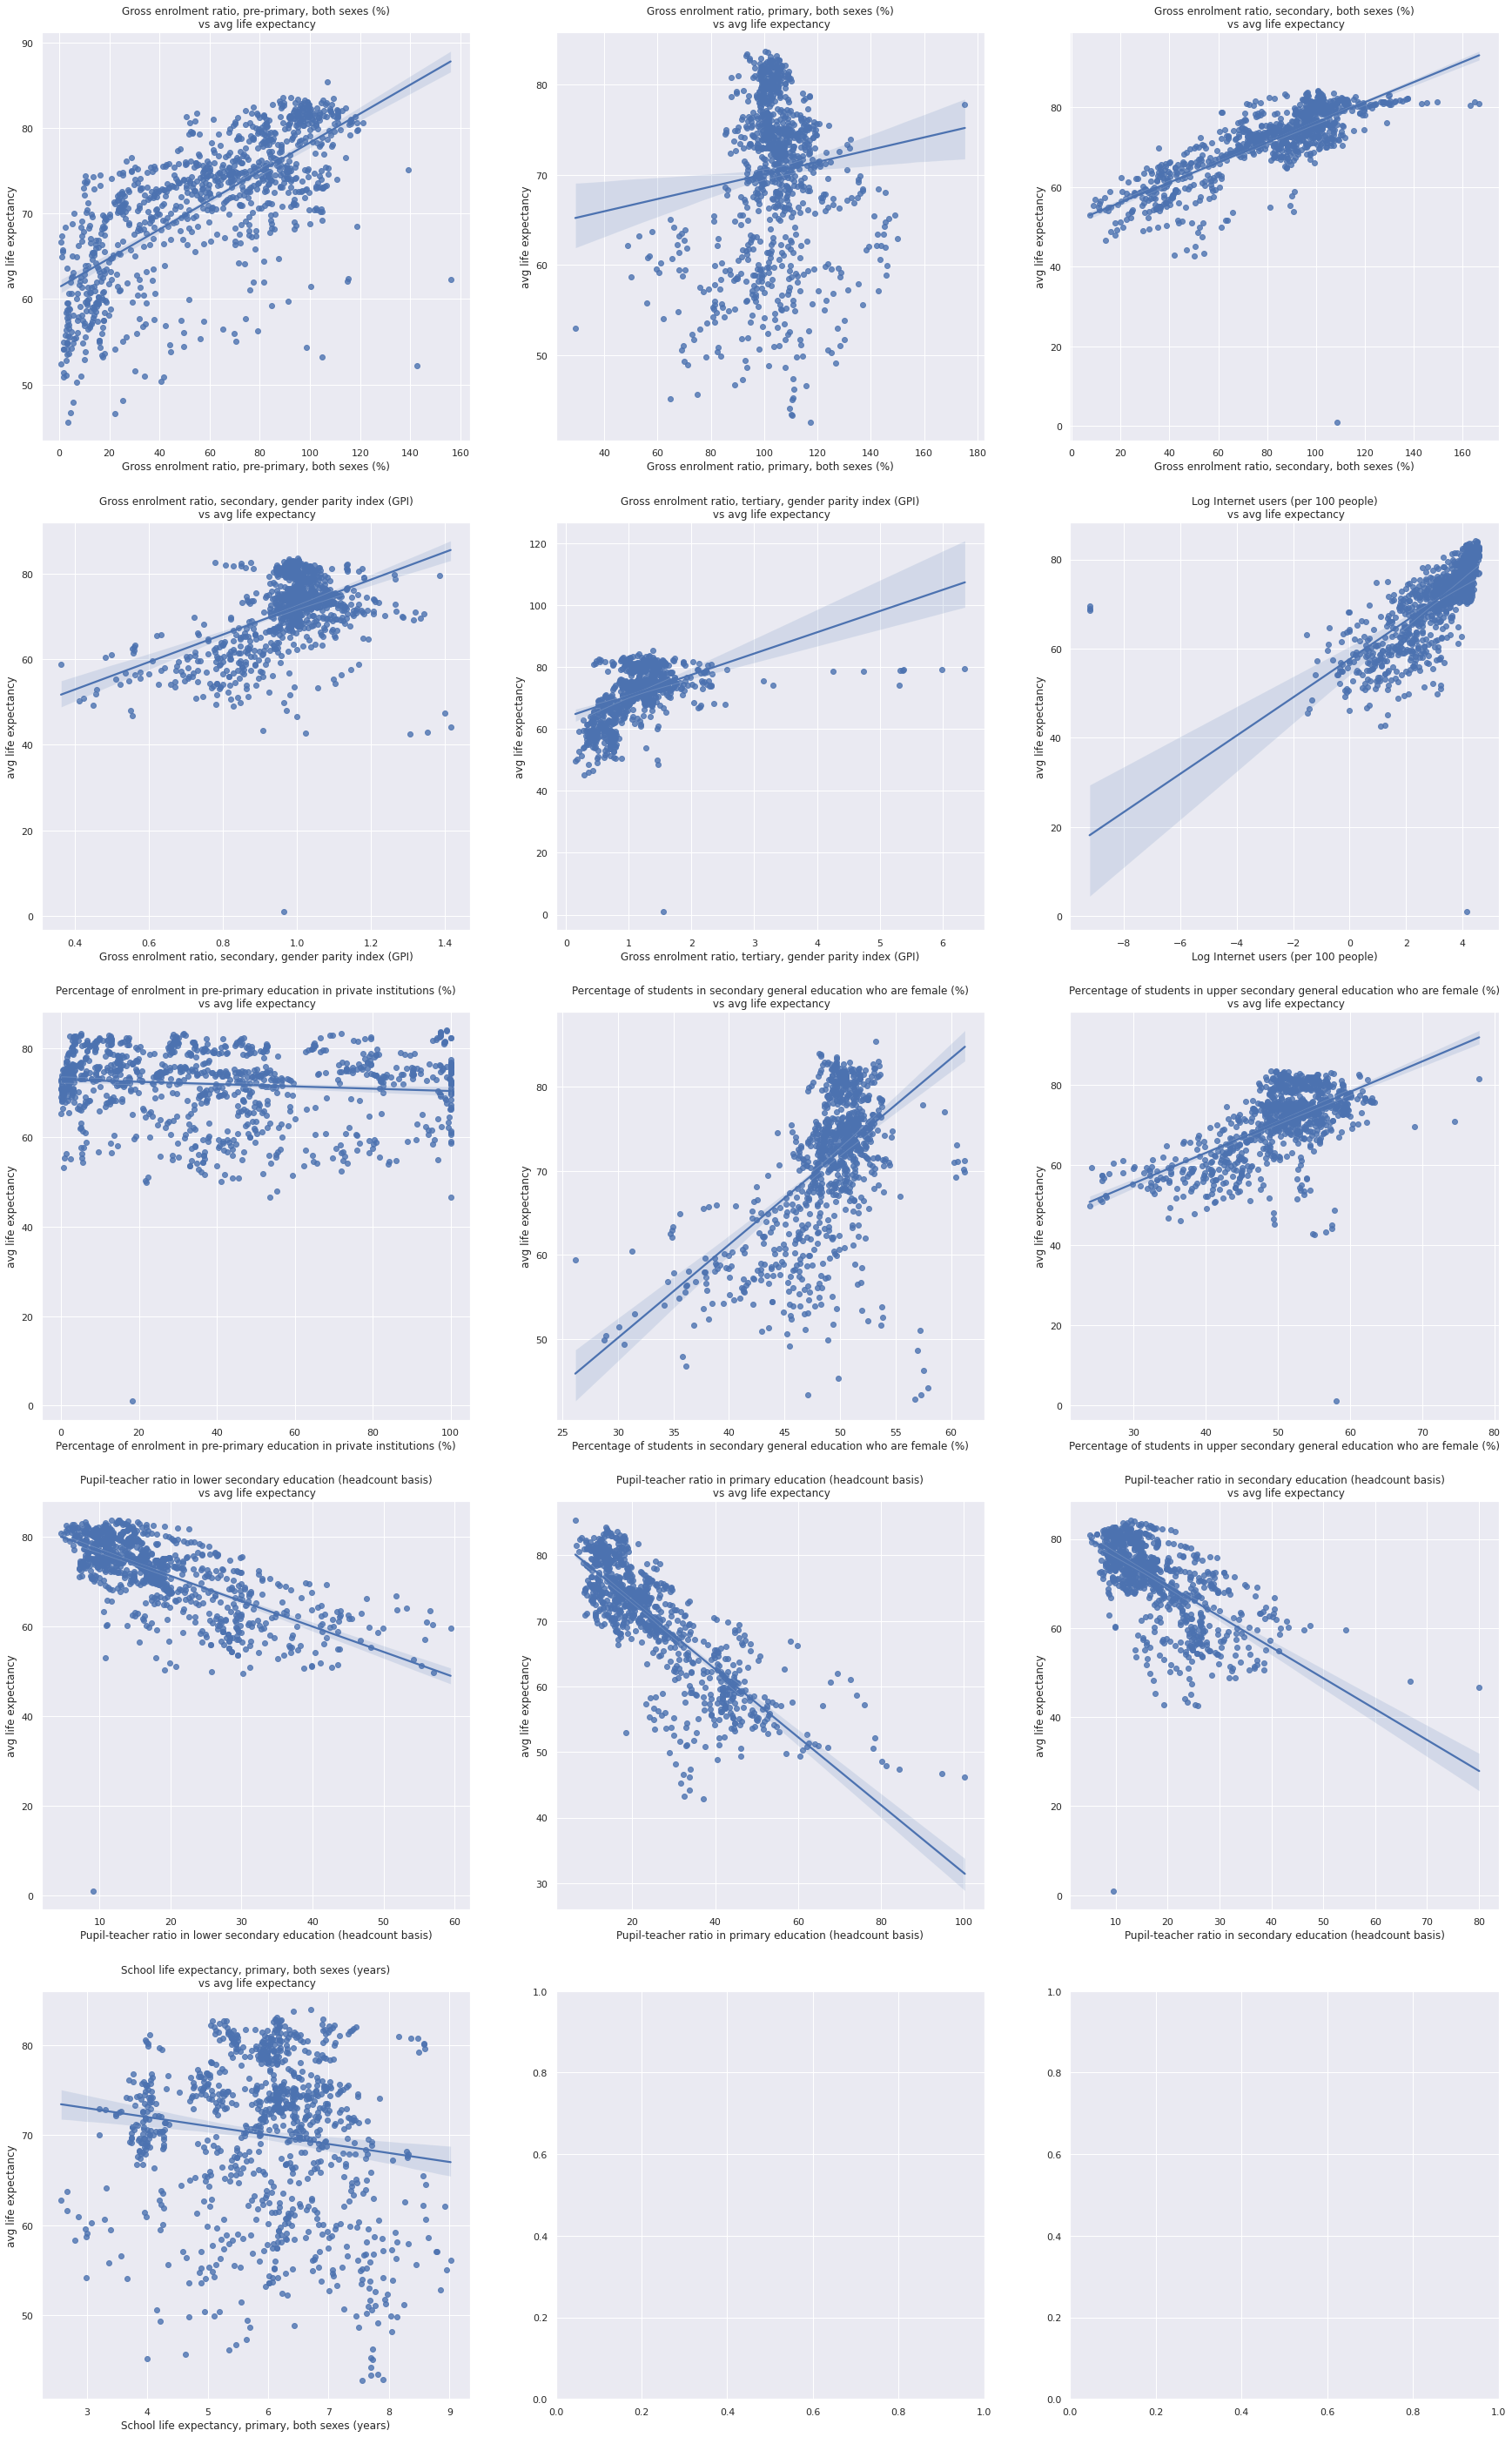

In [5]:
log_indics = ['Internet users (per 100 people)']
indics = np.unique(educ_life['indicator_name'])

columns = 3
rows = 5
fig, axs = plt.subplots(nrows=rows,ncols=columns, figsize=(30,50))

for count, indic in enumerate(indics):
  indic_df = educ_life[educ_life['indicator_name'] == indic][['avg_educ', 'avg_life']]
  if indic in log_indics:
    indic_df['avg_educ'] = np.log(indic_df['avg_educ'] + 0.0001)
  if indic_df.shape[0] > 1000:
    indic_df = indic_df.sample(1000)
  sns.regplot(x='avg_educ', y='avg_life', data=indic_df, ax=axs[count//columns][count%columns])
  log_prefix = 'Log 'if indic in log_indics else ''
  axs[count//columns][count%columns].set_xlabel(log_prefix + indic)
  axs[count//columns][count%columns].set_ylabel('avg life expectancy')
  axs[count//columns][count%columns].set_title(log_prefix + indic + '\n vs avg life expectancy')
plt.show()

We find that **gross enrollment ratio for primary and-pre primary education** shows a **weak correlation** to the target (= average  expected life expectancy at birth) while the **ratio for secondary education** shows a **stronger correlation**. This makes sense as enrolling in pre-primary and primary education is very common in a lot of countries, whereas enrolling in secondary education is a truer mark of importance given to education for a given country. We can expect that if the guardians are looking after the education of a child, then they will maintain the well being of the child as well.  

We also see that **Gross enrolment ratio, tertiary, gender parity index (GPI)** and **Percentage of students in secondary and upper secondary general education who are female (%)** have a strong correlation to the target, which makes sense as higher gender parity index in higher education indicates that the country is trying to provide equivalent resources to women as compared to men. This is a mark of a progressive nation, and therfore, higher life expectancy. Additionally, women generally get the shorter end of the stick when it comes to resource allocation. Therefore, an indicator which hints at gender parity also indicates that we can expect the average life expectancy of women to improve, thereby increasing the overall average.   

We expected **internet users per 100 people** to be a strong indicator of life expectancy as it could have been a proxy for technological advancements, but the plot shows a weak trend between them. The plot is heavly populated around 0, and then has a very weak increasing slope. This means that our hypothesis that internet is a proxy for technological advancemement is not entirely correct, the distribution for internet is very skewed. There are a lot of countries with very few internet users, and although their life expectancy is all over the range. Additionally, countries with more internet users do not have a significatnly better life expectancy. This indicates that internet accessibility is becoming common in other countries due to its huge demand but this growth is not accompanied by a wholistic technological advancement.

We also expected **Percentage of enrolment in pre-primary education in private institutions (%)** to indicate how much wealth guardians are willing to spend on their children given the higher cost of private education, and therefore correlate to the target. The plot, however, shows close to 0 relation between the two. This can be understood in two ways - pre-primary education is not necessarily a level where guardians would be willing to spend more on private education. Alternatively, we know that public institutions are in pretty bad shape in a lot of developing countries, and this void has been filled by private institutions that try to provide better education at reasonable prices to capitalize on the market. 

As expected, we found **pupil-teacher ratio** to be **strongly negatively correlated** to the target as it is a good indicator of the quality of education infrastructure. Poor education services don't really contribute towards life expectancy and are not indicative of a progressive nation or quality infrastructure. 

Finally, we found **school life expectancy** to be **mildly correlated** to the target. Low school life expectancy can indicate the inability of guardians to provide resources (for education or health) for the child. Sometimes children are forced to leave school and start earning for the family. 


## WDI

World development indicators (WDI) are obviosuly indicative of the level of development in a country. We hypothesize more developed countries (identified by positive wdi results) to have a higher life expectancy.

In [6]:
%%bigquery --project $project_id wdi_life

WITH wdi_indic AS (
    SELECT country_code, year, indicator_name, AVG(value) AS avg_wdi
    FROM `bigquery-public-data.world_bank_wdi.indicators_data` 
    WHERE indicator_name = 'Land area (sq. km)'
        OR indicator_name = 'Population density (people per sq. km of land area)'
        OR indicator_name = 'People using at least basic drinking water services (% of population)'
        OR indicator_name = 'Access to electricity (% of population)'
        OR indicator_name = 'Total fisheries production (metric tons)'
        OR indicator_name = 'Urban population growth (annual %)'
        OR indicator_name = 'Access to electricity, rural (% of rural population)'
        OR indicator_name = 'Urban population (% of total population)'
        OR indicator_name = 'People practicing open defecation (% of population)'
        OR indicator_name = 'People using at least basic sanitation services (% of population)'
        OR indicator_name = 'GDP per capita (current US$)'
        OR indicator_name = 'GDP (current US$)'
        OR indicator_name = 'Death rate, crude (per 1,000 people)'
        OR indicator_name = 'Birth rate, crude (per 1,000 people)'
        OR indicator_name = 'Diabetes prevalence (% of population ages 20 to 79)'
        OR indicator_name = 'Fertility rate, total (births per woman)'
        OR indicator_name = 'Physicians (per 1,000 people)'
        OR indicator_name = 'Total greenhouse gas emissions (kt of CO2 equivalent)'
        OR indicator_name = 'Merchandise imports (current US$)'
        OR indicator_name = 'Births attended by skilled health staff (% of total)'
        OR indicator_name = 'Foreign direct investment, net inflows (BoP, current US$)'
        OR indicator_name = 'Hospital beds (per 1,000 people)'
        OR indicator_name = 'Children out of school (% of primary school age)'
        OR indicator_name = 'Government expenditure on education, total (% of GDP)'
        OR indicator_name = 'Mortality rate, adult, female (per 1,000 female adults)'
        OR indicator_name = 'Condom use, population ages 15-24, male (% of males ages 15-24)'
        OR indicator_name = 'Condom use, population ages 15-24, female (% of females ages 15-24)'
        OR indicator_name = 'Contraceptive prevalence, any methods (% of women ages 15-49)'
        OR indicator_name = 'Contraceptive prevalence, modern methods (% of women ages 15-49)'
        OR indicator_name = 'Forest area (% of land area)'
    GROUP BY country_code, year, indicator_name
    HAVING year BETWEEN 2006 AND 2016
),
life_expec AS 
(
    SELECT country_code, year, AVG(value) AS avg_life
    FROM `bigquery-public-data.world_bank_health_population.health_nutrition_population`
    WHERE indicator_name = 'Life expectancy at birth, total (years)'
    GROUP BY country_code, year
    HAVING year BETWEEN 2006 AND 2016
)

SELECT wdi_indic.country_code, wdi_indic.year, indicator_name, avg_wdi, avg_life 
FROM wdi_indic 
JOIN life_expec 
    ON wdi_indic.country_code = life_expec.country_code
    AND wdi_indic.year = life_expec.year

We found some non-linear relationships between indicators and the target, so we transformed the indicator on log scale to capture the relationship. The indicators are liisted in log_indics list.

/usr/local/lib/python3.7/dist-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


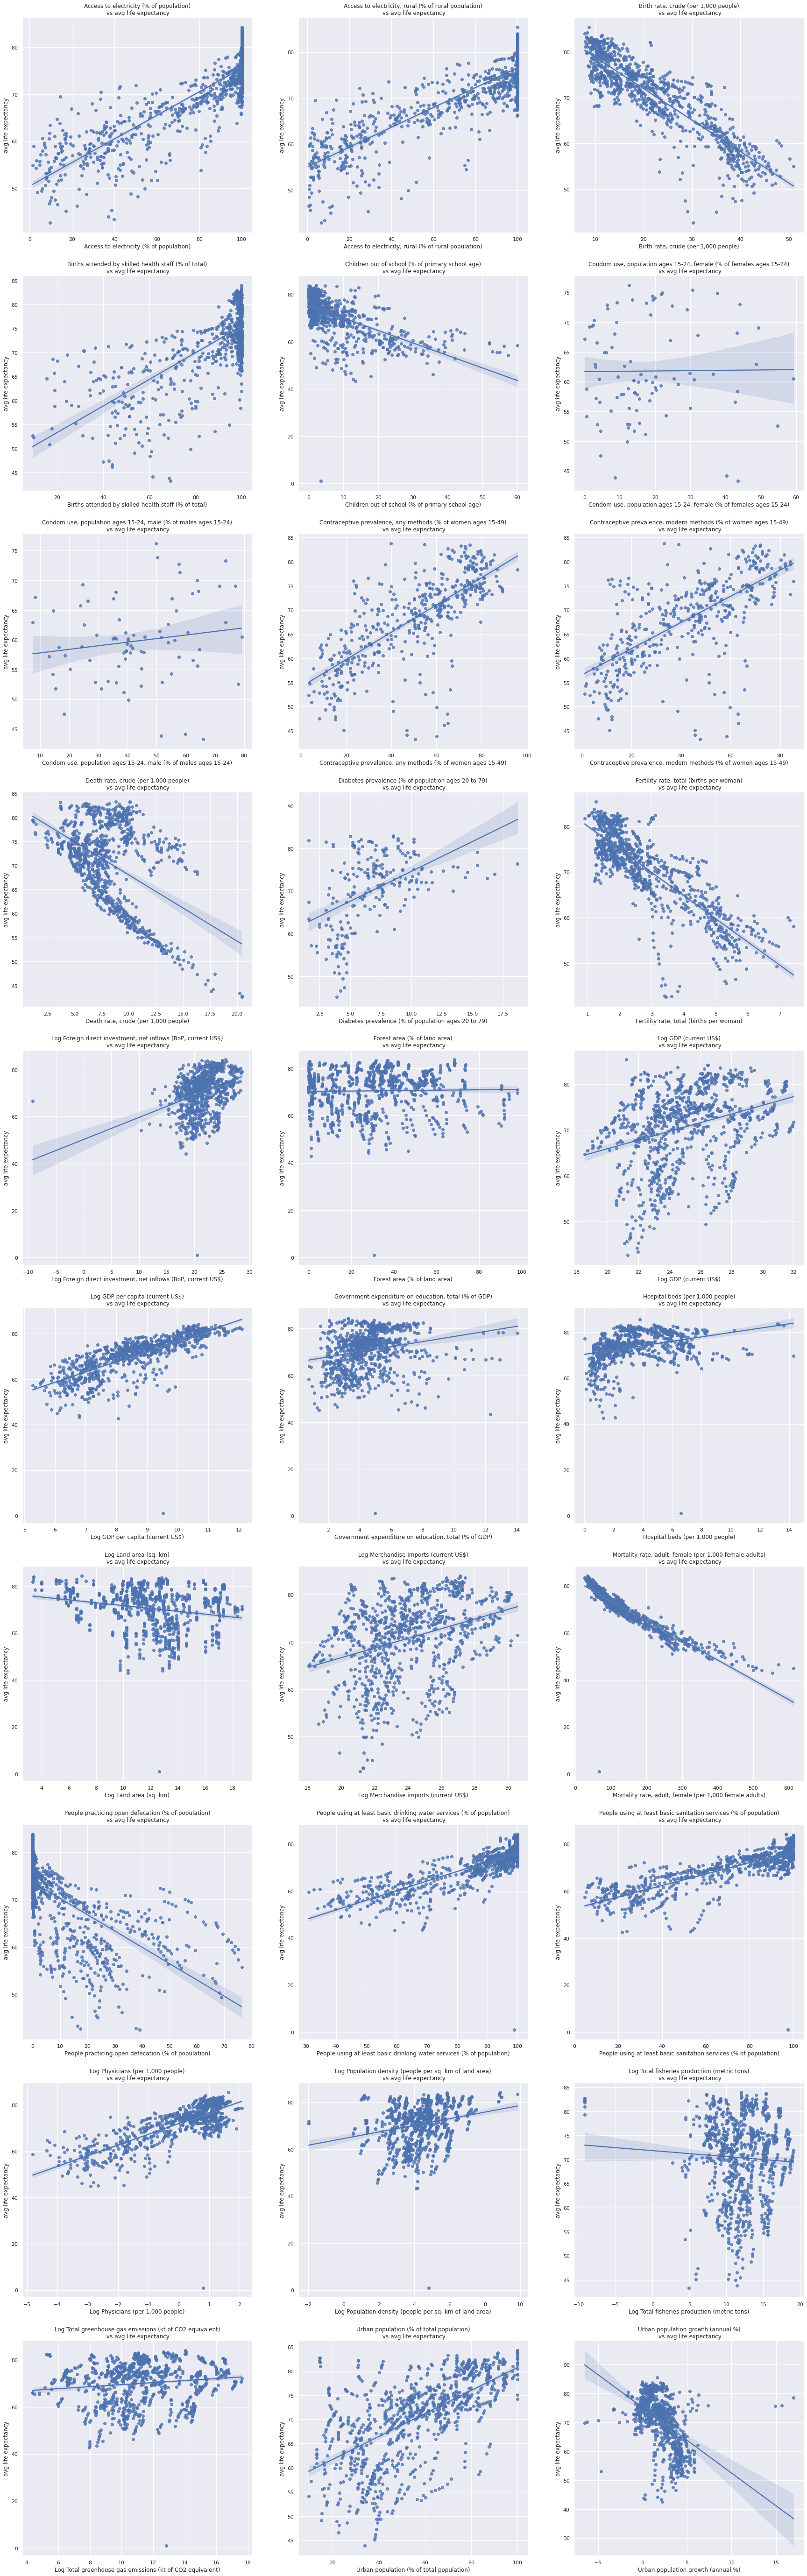

In [7]:
log_indics = ['Foreign direct investment, net inflows (BoP, current US$)', 'GDP (current US$)', 'GDP per capita (current US$)', 'Land area (sq. km)', 
              'Merchandise imports (current US$)', 'Population density (people per sq. km of land area)', 'Total fisheries production (metric tons)',
              'Total greenhouse gas emissions (kt of CO2 equivalent)', 'Physicians (per 1,000 people)']

indics = np.unique(wdi_life['indicator_name'])

columns = 3
rows = 10
fig, axs = plt.subplots(nrows=rows,ncols=columns, figsize=(30,100))

for count, indic in enumerate(indics):
  indic_df = wdi_life[wdi_life['indicator_name'] == indic][['avg_wdi', 'avg_life']]
  if indic in log_indics:
    indic_df['avg_wdi'] = np.log(indic_df['avg_wdi'] + 0.0001)
  if indic_df.shape[0] > 1000:
    indic_df = indic_df.sample(1000)
  sns.regplot(x='avg_wdi', y='avg_life', data=indic_df, ax=axs[count//columns][count%columns])
  log_prefix = 'Log 'if indic in log_indics else ''
  axs[count//columns][count%columns].set_xlabel(log_prefix + indic)
  axs[count//columns][count%columns].set_ylabel('avg life expectancy')
  axs[count//columns][count%columns].set_title(log_prefix + indic + '\n vs avg life expectancy')
plt.show()

We found that access to electricity has a strong correlation to the average life expectancy. Electricity is a good indicator of living conditions of people, which is very heavily linked to life expectancy. We also tried to split the access to electricity off of if people live in rural or urban areas, but did not find any additional insights from this split.

We also found birth rates and fertility rates to be negatively correlated to life expectancy. High birth rates and fertility rates can be an indicator of overpopulation which strains the resources and adversely affects life expectancy. High Births attended by skilled staff also showed a weak correlation to the target. Complications during birth can affect the future health of the baby so this relation makes sense. Skilled staff also indicate that the country has good health infrastructure.

Children out of school indicates the inability of guardians to provide resources (for education or health) for the child. Sometimes children are forced to leave school and start earning for the family. Therefore, the negative correlation between this indicator and the target makes sense.

Condom use for both men and women did not show strong correlation with the target, whereas contraceptive prevalence for women showed a strong correlation. Using contraceptive methods indicates better family planning, which means that the parents feel ready to provide for the child and therefore, the child can be expected to have a healthy life. Condoms, in particular, are not the preferred contraceptive method (especially in developing countries) due to the taboo associated with them and we think this factors into the data as well.

Death rate and mortality rates, for obvious reasons, is strongly negatively correlated to the life expectancy as more deaths mean people live less.

We found diabetes prevalence to have a positive effect on life expectancy which is quite surprising. We think this can be attributed to diabetes being a first world disease. As in, diabetes isn't treated with seriousness in developing countries who therefore, won't report a lot of diabetes cases. Countries actively reporting diabetes give emphasis on the health of its citizens and are actively promoting diabetes testing, and by extension, other healthcare tests. This indicates that the country is actively working for the health of its citizens. 

Financial indicators like GDP per capita, foreign investments, imports, government expenditure on education show a positive dependence on the target. GDP per capita, in particular, is strongly correlated to life expectancy. A strong financial state of a country implies that the citizens have the resources to improve their health, which is why there's a positive correlation between financial indicators and average life expectancy.

Land area and forest area are not very indicative of average life expectancy because they capture very primitive information. When processed further into more complex features like population density, they show a better dependence.

Health infrastructure indicators like hospital beds and physicians show a positive dependence with the target, which is not surprising as better health infrastructure supports the health of more people and therefore improves their life expectancy.

Sanitary indicators like access to safe drinking water, open defecation, and basic sanitary services also show a strong dependence on the target. People interact with these factors over a long period of time, and therefore, these factors have a strong influence on the health of people.

Urban population as a percentage of total population shows a positive correlation with the target, as more urban population is indicative of better access to health infrastructure which tends to be concentrated in cities. The growth of urban population, however, shows a strong negative correlation to life expectancy. This makes sense as too high of an increase in urban population does not allow the cities to develop the infrastruture to handle the surge in population. This pushes the urban immigrants to live in poor living conditions which deteriorates their health.

CO2 emmision and number of fisheries do not show a strong dependence on the target as on their own, they capture very crude information to directly be of use for predicting life expectancy.

## Health

Indicators measuring health of a country are obviously expected to play a role in predicting the life expectancy. We hypothetize that countries with developed health infrastructure and with citizens actively taking steps to improve their health to have a higher life expectancy.


In [8]:
%%bigquery --project $project_id health_life

WITH health_life AS (
    SELECT country_code, year, indicator_name, AVG(value) AS avg_health
    FROM `bigquery-public-data.world_bank_health_population.health_nutrition_population` 
    WHERE indicator_name = 'People using at least basic drinking water services (% of population)'
        OR indicator_name = 'People using at least basic sanitation services (% of population)'
        OR indicator_name = 'Literacy rate, youth total (% of people ages 15-24)'
        OR indicator_name = 'Prevalence of syphilis (% of women attending antenatal care)'
        OR indicator_name = 'Prevalence of current tobacco use, females (% of female adults)'
        OR indicator_name = 'Prevalence of overweight (modeled estimate, % of children under 5)'
        OR indicator_name = 'Prevalence of stunting, height for age (modeled estimate, % of children under 5)'
        OR indicator_name = 'Literacy rate, youth total (% of people ages 15-24)'
        OR indicator_name = 'Immunization, BCG (% of one-year-old children)'
        OR indicator_name = 'Literacy rate, adult total (% of people ages 15 and above)'
        OR indicator_name = 'Prevalence of undernourishment (% of population)'
        OR indicator_name = 'Domestic general government health expenditure (% of general government expenditure)'
        OR indicator_name = 'Immunization, measles second dose (% of children by the nationally recommended age)'
        OR indicator_name = 'Specialist surgical workforce (per 100,000 population)'
        OR indicator_name = 'People using at least basic drinking water services, urban (% of urban population)'
        OR indicator_name = 'Mortality rate attributed to unintentional poisoning (per 100,000 population)'
        OR indicator_name = 'Mortality rate attributed to unsafe water, unsafe sanitation and lack of hygiene, male (per 100,000 male population)'
        OR indicator_name = 'Suicide mortality rate (per 100,000 population)'
        OR indicator_name = 'Mortality caused by road traffic injury, male (per 100,000 male population)'
        OR indicator_name = 'Mortality from CVD, cancer, diabetes or CRD between exact ages 30 and 70'
        OR indicator_name = 'Tuberculosis death rate (per 100,000 people)'
        OR indicator_name = 'Cause of death, by injury (% of total)'
        OR indicator_name = 'Mortality rate attributed to household and ambient air pollution (per 100,000 population)'
        OR indicator_name = 'Cause of death, by communicable diseases and maternal, prenatal and nutrition conditions (% of total)'
        OR indicator_name = 'Mortality rate attributed to unsafe water, unsafe sanitation and lack of hygiene (per 100,000 population'
        OR indicator_name = 'Lifetime risk of maternal death (%)'
        OR indicator_name = 'Immunization, HepB3 (% of one-year-old children)'
        OR indicator_name = 'Total alcohol consumption per capita (liters of pure alcohol, projected estimates, 15+ years of age)'
        OR indicator_name = 'Prevalence of overweight (% of adults)'
        OR indicator_name = 'Immunization, Hib3 (% of children ages 12-23 months)'
        OR indicator_name = 'Prevalence of anemia among pregnant women (%)'
        OR indicator_name = 'Prevalence of anemia among children (% of children ages 6-59 months)'
        OR indicator_name = 'Mortality caused by road traffic injury (per 100,000 people)'
        OR indicator_name = 'Current health expenditure (% of GDP)'
        OR indicator_name = 'Domestic general government health expenditure per capita, PPP (current international $)'
        OR indicator_name = 'Domestic private health expenditure per capita (current US$)'
        OR indicator_name = 'Immunization, DPT (% of children ages 12-23 months)'
        OR indicator_name = 'Immunization, measles (% of children ages 12-23 months)'
        OR indicator_name = 'Immunization, Pol3 (% of one-year-old children)'
        OR indicator_name = 'Mortality rate, infant (per 1,000 live births)'
        OR indicator_name = 'Probability of dying among adolescents ages 15-19 years (per 1,000)'
        OR indicator_name = 'Probability of dying among youth ages 20-24 years (per 1,000)'
        OR indicator_name = 'Probability of dying among adolescents ages 10-14 years (per 1,000)'
        OR indicator_name = 'Probability of dying among children ages 5-9 years (per 1,000)'
        OR indicator_name = 'Age dependency ratio (% of working-age population)'
        OR indicator_name = 'Physicians (per 1,000 people)'
        OR indicator_name = 'Hospital beds (per 1,000 people)'
    GROUP BY country_code, year, indicator_name
    HAVING year BETWEEN 2006 AND 2016
),
life_expec AS (
    SELECT country_code, year, AVG(value) AS avg_life
    FROM `bigquery-public-data.world_bank_health_population.health_nutrition_population`
    WHERE indicator_name = 'Life expectancy at birth, total (years)'
    GROUP BY country_code, year
    HAVING year BETWEEN 2006 AND 2016
)

SELECT health_life.country_code, health_life.year, indicator_name, avg_health, avg_life
FROM health_life 
JOIN life_expec 
    ON health_life.country_code = life_expec.country_code
    AND health_life.year = life_expec.year

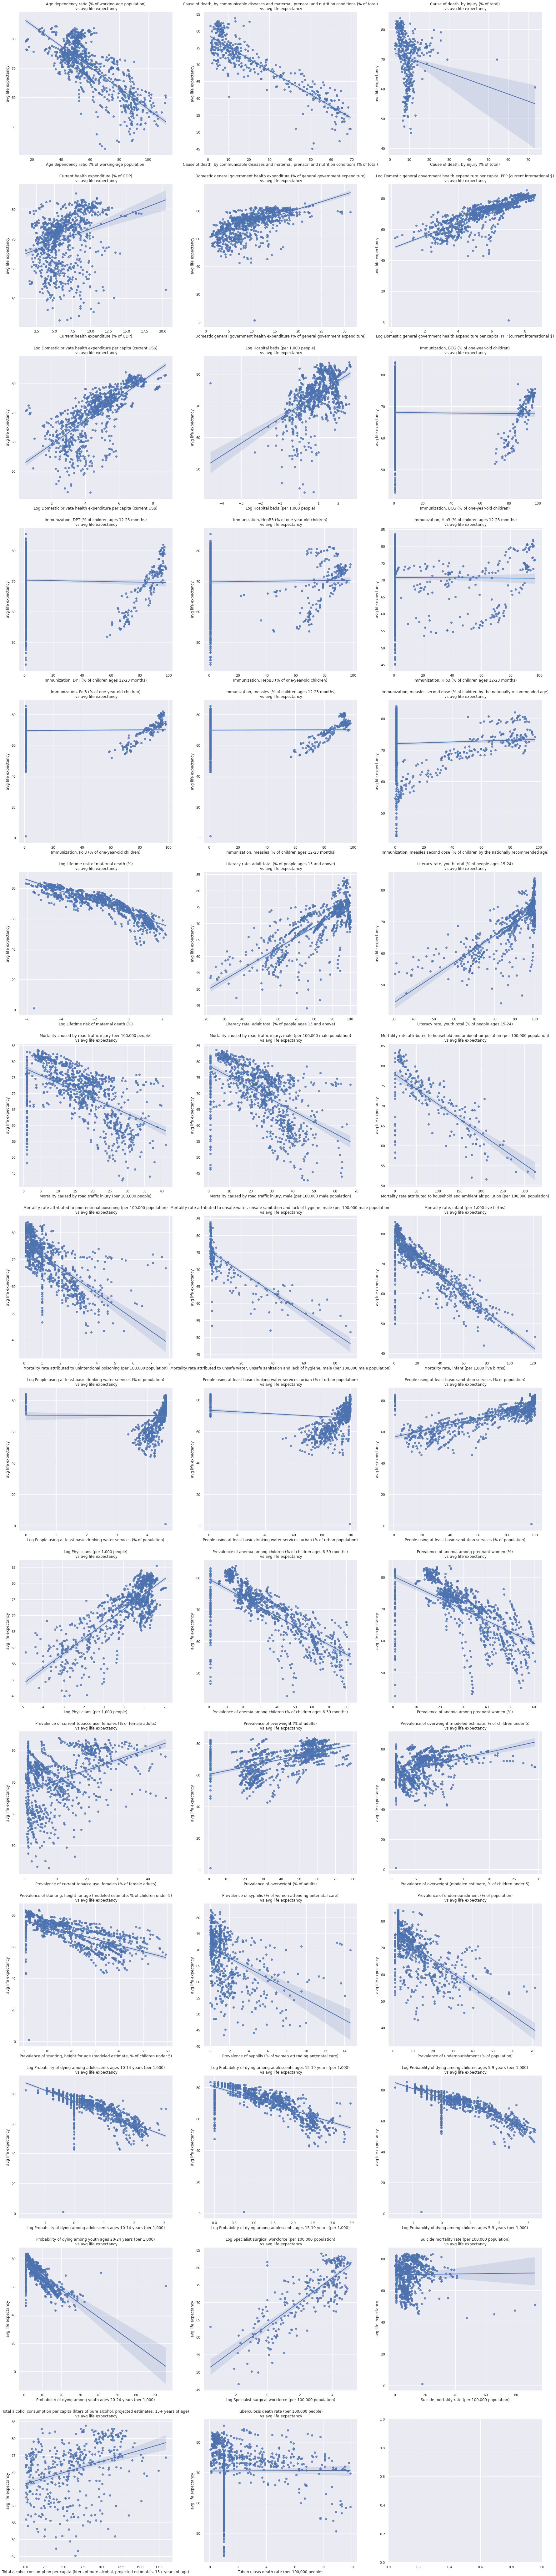

In [9]:
log_indics = ['Domestic general government health expenditure per capita, PPP (current international $)', 'Domestic private health expenditure per capita (current US$)',
              'Lifetime risk of maternal death (%)', 'Mortality rate attributed to unsafe water, unsafe sanitation and lack of hygiene (per 100,000 population',
              'People using at least basic drinking water services (% of population)', 'Probability of dying among adolescents ages 10-14 years (per 1,000)',
              'Probability of dying among adolescents ages 15-19 years (per 1,000)', 'Probability of dying among children ages 5-9 years (per 1,000)',
              'Specialist surgical workforce (per 100,000 population)', 'Hospital beds (per 1,000 people)', 'Physicians (per 1,000 people)']

indics = np.unique(health_life['indicator_name'])

columns = 3
rows = 15
fig, axs = plt.subplots(nrows=rows,ncols=columns, figsize=(30,150))

for count, indic in enumerate(indics):
  indic_df = health_life[health_life['indicator_name'] == indic][['avg_health', 'avg_life']]
  if indic in log_indics:
    indic_df['avg_health'] = np.log(indic_df['avg_health'] + 0.0001)
  if indic_df.shape[0] > 1000:
    indic_df = indic_df.sample(1000)
  sns.regplot(x='avg_health', y='avg_life', data=indic_df, ax=axs[count//columns][count%columns])
  log_prefix = 'Log 'if indic in log_indics else ''
  axs[count//columns][count%columns].set_xlabel(log_prefix + indic)
  axs[count//columns][count%columns].set_ylabel('avg life expectancy')
  axs[count//columns][count%columns].set_title(log_prefix + indic + '\n vs avg life expectancy')
plt.show()

Age dependency ratio is negative correlated to the target, as the working population needing to support more people means that the dependent population gets a lower share of resources.

Cause of death, mortality rate and probability of dying is negative correlated as people dying of any reasons reduces the average life expectancy.

Government expenditure on health is positvely correlated to the target as the government's efforts on improving the health of its citizens translate into better health of the citizens, and therefore, a higher life expectancy. Private health expenditure is also positively correlated as people spending money on their health ensures that they live longer.

Immunization graphs are heavily skewed towards 0 as a lot of countries do not provide vaccinations. Of the non-zero values, there's a clear positve correlation to life expectancy as vaccines make people immune to potentially deadly diseases.

Lifetime risk of maternal death is negatively correlated to the target as it indicates a lack of childbirth and childcare fascilities which can result in loss of the mother's and/or the child's life.

Literacy rate shows a positve correlation as it indicates government's effort to improve the lives of its citizens and as it also makes people aware of health hazards and how to deal with them.

Sanitary indicators like access to safe drinking water, open defecation, and basic sanitary services also show a strong dependence on the target. People interact with these factors over a long period of time, and therefore, these factors have a strong influence on the health of people.

Prevalence of anaemia and syhpilis in pregnant women and children is strongly negatively correlated to life expectancy as they health of pregnant women and children is more vulnerable as compared to adults.

Prevalence of tobacco use, alcohol consumption and overweight show a weak positive correlation to the target which is surprising. This can probably be attributed to these factors are more common in a devloped country with high life expectancy.

Prevalence of stunting and undernourishment are negatively correlated to the target as they clearly shows that people aren't getting the proper nourishment needed for a healthy life.

Presence of specialized surgical workforce is a good indicator of the quality of health infrastructure, and is therefore strongly correlated to life expectancy.

Tuberculosis death rate shows a negative correlation to the target, although the data is skewed at a paricular level potentially due to data collection discrepancy.




## Population

A higher population increases competition of resources in a country which leads to some segments being deprived of proper care required for a healthy life.  

In [10]:
%%bigquery --project $project_id pop_life

WITH pop AS (
    SELECT country_code, year_2018 AS avg_population
    FROM `bigquery-public-data.world_bank_global_population.population_by_country`
),
life_expec AS 
(
    SELECT country_code, year, AVG(value) AS avg_life
    FROM `bigquery-public-data.world_bank_health_population.health_nutrition_population`
    WHERE indicator_name = 'Life expectancy at birth, total (years)'
    GROUP BY country_code, year
    HAVING year = 2018
)

SELECT pop.country_code, year, avg_life, avg_population
FROM pop 
JOIN life_expec 
    ON pop.country_code = life_expec.country_code

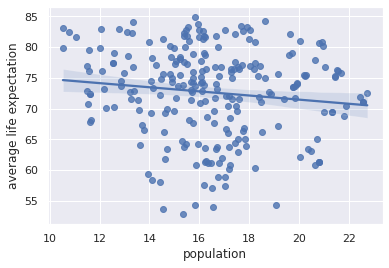

In [11]:
pop_life['log avg_population'] = np.log(pop_life['avg_population'])
sns.regplot(x = 'log avg_population', y = 'avg_life', data = pop_life)
plt.xlabel('population')
plt.ylabel('average life expectation')
plt.show()

Population by itself doesn't capture the competition for resources. For instance, a larger country with a large amount of resources is able to sustain a high life expectancy but a similar size country with fewer resources might not have the same life expectancy. Therefore, there's only a weak negative correlation of population with life expectancy.

## Debt

In [12]:
%%bigquery --project $project_id debt_life

WITH debt AS (
    SELECT country_code, indicator_name, AVG(value) AS avg_debt
    FROM `bigquery-public-data.world_bank_intl_debt.international_debt` 
    WHERE indicator_name = 'Principal repayments on external debt, public and publicly guaranteed (PPG) (AMT, current US$)'
        OR indicator_name = 'Principal repayments on external debt, private nonguaranteed (PNG) (AMT, current US$)'
        OR indicator_name = 'Principal repayments on external debt, long-term (AMT, current US$)'
        OR indicator_name = 'PPG, private creditors (INT, current US$)'
        OR indicator_name = 'PPG, private creditors (DIS, current US$)'
        OR indicator_name = 'PPG, private creditors (AMT, current US$)'
        OR indicator_name = 'PPG, other private creditors (INT, current US$)'
        OR indicator_name = 'PPG, other private creditors (DIS, current US$)'
        OR indicator_name = 'PPG, other private creditors (AMT, current US$)'
        OR indicator_name = 'PPG, official creditors (INT, current US$)'
        OR indicator_name = 'PPG, official creditors (DIS, current US$)'
        OR indicator_name = 'PPG, official creditors (AMT, current US$)'
        OR indicator_name = 'PPG, multilateral (INT, current US$)'
        OR indicator_name = 'PPG, multilateral (DIS, current US$)'
        OR indicator_name = 'PPG, multilateral (AMT, current US$)'
        OR indicator_name = 'PPG, commercial banks (INT, current US$)'
        OR indicator_name = 'PPG, commercial banks (DIS, current US$)'
        OR indicator_name = 'PPG, commercial banks (AMT, current US$)'
        OR indicator_name = 'PPG, bonds (INT, current US$)'
        OR indicator_name = 'PPG, bonds (AMT, current US$)'
        OR indicator_name = 'PPG, bilateral (INT, current US$)'
        OR indicator_name = 'PPG, bilateral (DIS, current US$)'
        OR indicator_name = 'PPG, bilateral (AMT, current US$)'
        OR indicator_name = 'Interest payments on external debt, private nonguaranteed (PNG) (INT, current US$)'
        OR indicator_name = 'Interest payments on external debt, long-term (INT, current US$)'
        OR indicator_name = 'Disbursements on external debt, public and publicly guaranteed (PPG) (DIS, current US$)'
        OR indicator_name = 'Disbursements on external debt, long-term (DIS, current US$)'
    GROUP BY country_code, indicator_name
),
life_expec AS 
(
    SELECT country_code, AVG(value) AS avg_life
    FROM `bigquery-public-data.world_bank_health_population.health_nutrition_population`
    WHERE indicator_name = 'Life expectancy at birth, total (years)'
    GROUP BY country_code
)

SELECT debt.country_code, debt.indicator_name, avg_debt, avg_life
FROM debt 
JOIN life_expec 
    ON debt.country_code = life_expec.country_code

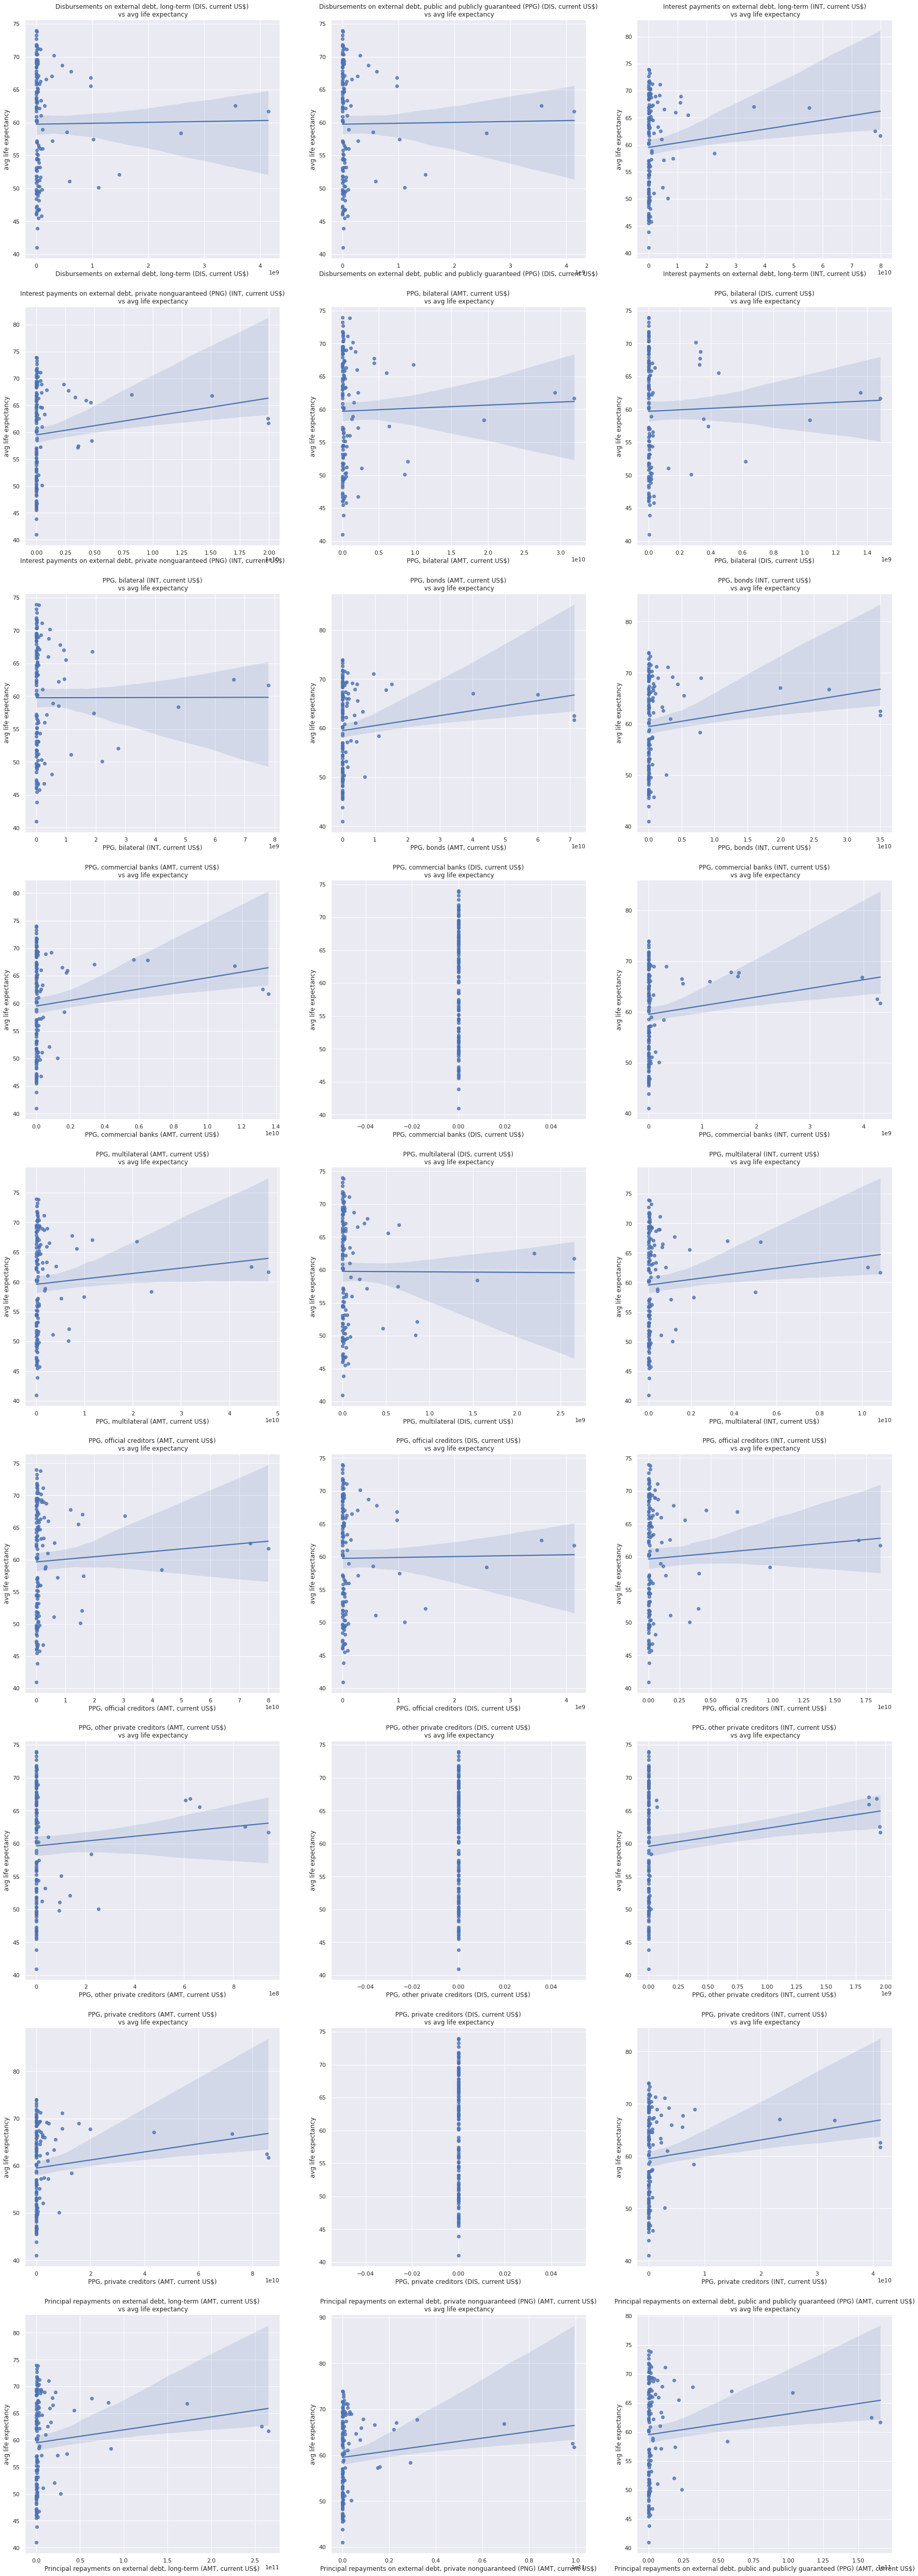

In [13]:
indics = np.unique(debt_life['indicator_name'])

columns = 3
rows = 9
fig, axs = plt.subplots(nrows=rows,ncols=columns, figsize=(30,90))

for count, indic in enumerate(indics):
  indic_df = debt_life[debt_life['indicator_name'] == indic][['avg_debt', 'avg_life']]
  if indic_df.shape[0] > 1000:
    indic_df = indic_df.sample(1000)
  sns.regplot(x='avg_debt', y='avg_life', data=indic_df, ax=axs[count//columns][count%columns])
  axs[count//columns][count%columns].set_xlabel(indic)
  axs[count//columns][count%columns].set_ylabel('avg life expectancy')
  axs[count//columns][count%columns].set_title(indic+'\n vs avg life expectancy')
plt.show()

In [14]:
%%bigquery --project $project_id debt_indic_total_count

SELECT COUNT(DISTINCT indicator_name) AS num_indicators
FROM `bigquery-public-data.world_bank_intl_debt.international_debt`

In [15]:
print(debt_indic_total_count.head())

   num_indicators
0             497


In [16]:
%%bigquery --project $project_id debt_indic_non_null_count

SELECT COUNT(DISTINCT indicator_name) AS num_indicators
FROM `bigquery-public-data.world_bank_intl_debt.international_debt`
WHERE value IS NOT NULL

In [17]:
print(debt_indic_non_null_count.head())

   num_indicators
0              27


In [18]:
%%bigquery --project $project_id debt_indic_non_null_count_with_date

SELECT COUNT(DISTINCT indicator_name) AS num_indicators
FROM `bigquery-public-data.world_bank_intl_debt.international_debt`
WHERE value IS NOT NULL
    AND year IS NOT NULL

In [19]:
print(debt_indic_non_null_count_with_date.head())

   num_indicators
0               0


After our initial analysis, we decided not to use the debt dataset for the following reasons: 

1.   Most indicators have null values. Only around ~5% (27/497) of indicators have non-null values
2.   The year field for all rows that have values is **null** making it hard to join with our life expectancy dataset.
3.   For the few indicators that do have values, the values are skewed towards 0 thus there's little to no information of these indicators for multiple countries.

## Custom indicators

We joined the indicators that were predictive from our analysis of the above datasets with life expectancy values and saved them in separate tables. This allows us to directly pick them without needing to compute them from the World Bank datsets again. We make the following new tables - 


*   **educ_life_2** - Indicators from the World Bank education dataset that are useful joined with life expectancy. Primary key - country_code, year, indicator_name. Foreign key - country_code, year
*   **health_life_2** - Indicators from the World Bank health dataset that are useful joined with life expectancy. Primary key - country_code, year, indicator_name. Foreign key - country_code, year
* **wdi_life** - Indicators from the World Bank WDI dataset that are useful joined with life expectancy. Primary key - country_code, year, indicator_name. Foreign key - country_code, year.
* **pop_life** - Population values from the year 1998-2018 joined with life expectancy. Primary key - country_code, year values from 1998 to 2018. Foreign key - country_code.

Next, we engineered custom features from the World Bank data tables using our existing knowledge and insights gained from the data analysis.

###1. Population Rate of Change

In [20]:
%%bigquery --project $project_id pop_life

SELECT * FROM `cs145-trial.trial1.pop_life` 

In [21]:
pop_rate_change = pd.DataFrame()
pop_rate_change['country_code'] = pop_life['country_code']
pop_rate_change['avg_life'] = pop_life['avg_life']
rate_change = (pop_life['year_1999'] - pop_life['year_1998']) / pop_life['year_1998'] 
for i in range(2006, 2017):
  rate_change += (pop_life['year_'+str(i+1)] - pop_life['year_'+str(i)]) / pop_life['year_'+str(i)]
pop_rate_change['rate_change'] = rate_change

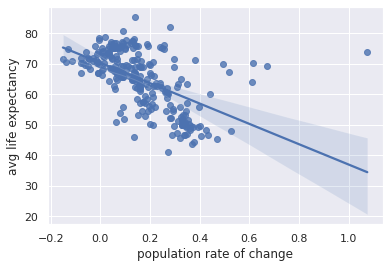

In [22]:
sns.regplot(x='rate_change', y='avg_life', data=pop_rate_change)
plt.xlabel('population rate of change')
plt.ylabel('avg life expectancy')
plt.show()

We were trying to access whether the rate of change for a given population might be correlated to the life expectancy of a given population. Our hypothesis was that they might be loosely correlated (either positively or negatively) for the following reasons:

1.   We hypothesize that an increase in life expectancy for a given population might be loosely correlated to postive population rate of change because the longer the lifespan for a given population is, the more likely it is to grow faster. 
2.   Another hypothesis we had was that a high rate of population growth might be loosely correlated to lower life expectancy. Our rationale for this was that as the population grows, there might be fewer health resources allocated per individual (resources spreading thin), thus might lead to a lower life expectancy.
3.   Last hypothesis we had was that a positive rate of population growth might be loosely correlated to lower life expectancy because countries with high population growth are normally underdevloped / developing countries which normally have a lower life expectancy than developed nations due to lacking infrastructure.

After looking into the data, we realized that there was a loose negative correlation between population rate of change and life expectancy at birth indicating our 2nd and 3rd hypothses are potentially true. Our first hypothesis could still be true (life expectancy does play at part in population rate of change) but it's not as significant as we expected it to be due to the slight negative correlation.

### 2. Primary to Secondary ratio female

In [23]:
%%bigquery --project $project_id pri_sec_ratio

WITH pri_sec_ratio_life AS (
    SELECT 
        T_primary.country_code AS country_code,
        T_primary.year,
        CASE
            WHEN secondary != 0 THEN primary / secondary
            ELSE primary
        END
        AS pri_sec_ratio
    FROM (
        SELECT country_code, year, AVG(value) AS primary
        FROM `bigquery-public-data.world_bank_intl_education.international_education` 
        WHERE indicator_name = 'Enrolment in primary education, female (number)'
        GROUP BY country_code, year
    ) AS T_primary,
    (
        SELECT country_code, year, AVG(value) AS secondary
        FROM `bigquery-public-data.world_bank_intl_education.international_education` 
        WHERE indicator_name = 'Enrolment in secondary education, female (number)'
        GROUP BY country_code, year
    ) AS T_secondary
    WHERE T_primary.country_code = T_secondary.country_code
        AND T_primary.year = T_secondary.year
),
life_expec AS 
(
    SELECT country_code, year, AVG(value) AS avg_life
    FROM `bigquery-public-data.world_bank_health_population.health_nutrition_population`
    WHERE indicator_name = 'Life expectancy at birth, total (years)'
    GROUP BY country_code, year
)

SELECT 
    life_expec.country_code,
    life_expec.year,
    CASE
        WHEN pri_sec_ratio = 0 THEN 0.0001
        ELSE pri_sec_ratio
    END AS pri_sec_ratio,
    avg_life
FROM pri_sec_ratio_life 
JOIN life_expec 
    ON pri_sec_ratio_life.country_code = life_expec.country_code
    AND pri_sec_ratio_life.year = life_expec.year
WHERE pri_sec_ratio_life.year BETWEEN 2006 AND 2016

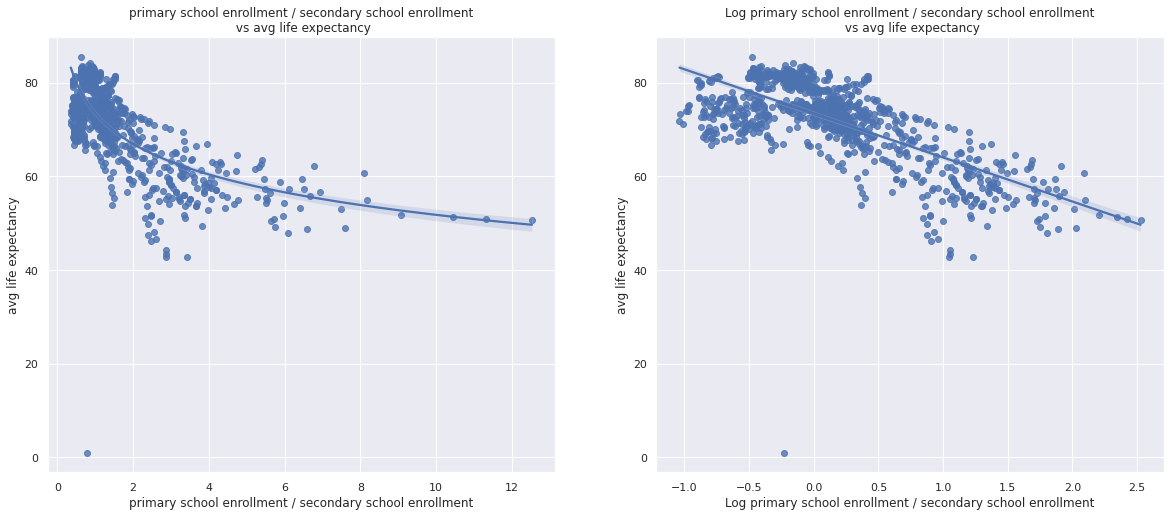

In [25]:
fig, axs = plt.subplots(1,2, figsize=(20, 8))
x_axis = 'primary school enrollment / secondary school enrollment'
if pri_sec_ratio.shape[0] > 1000:
  pri_sec_ratio = pri_sec_ratio.sample(1000)
sns.regplot(x='pri_sec_ratio', y='avg_life', data=pri_sec_ratio, logx=True, ax=axs[0])
axs[0].set_xlabel(x_axis)
axs[0].set_ylabel('avg life expectancy')
axs[0].set_title(x_axis+'\n vs avg life expectancy')

pri_sec_ratio['Log '+x_axis] = np.log(pri_sec_ratio['pri_sec_ratio'])
sns.regplot(x='Log '+x_axis, y='avg_life', data=pri_sec_ratio, ax=axs[1])
axs[1].set_xlabel('Log '+x_axis)
axs[1].set_ylabel('avg life expectancy')
axs[1].set_title('Log '+x_axis+'\n vs avg life expectancy')

plt.show()

Our hypothesis behind this feature was rooted in our previous explorations of the education dataset. We noticed a stronly positive correlation between secondary school enrollments and average expected life expectancy at birth versus the weak correlation we saw for primary school enrollment. We hypothesized that this might have been due to the fact that it's fairly standard for any country to have basic primary education infrastructure but it's more rare for a country to have secondary schooling infrastructure. Hence, secondary school enrollments were a stronger indicator of the infrastructure and technological progression of a country. 

We tried to build on this learning by also analyzing what the correlation between life expectancy and the enrollment ratio between primary and secondary schools. The premise behind this hypothesis was that given what we learned, the ratio between the two enrollments should also be strongly correlated because:


1.   When both primary and secondary enrollments are high, we predict that the country is well developed and has a solid infrastructure in place and thus should have a high life expectancy.
2.   When only primary enrollments are high but secondary enrollments are low, we postulate that the country will have a low life expectancy given the fact that the secondary enrollments are correlated to life expectancy.
3.   And the cases when both are low or only primary is low is an unlikely scenario given that primary education rates on average were around ~80% at a high glance.

Luckily, the enrollment ratio between primary and secondary education did in fact have a strong negative correlation to life expectancy, as we expected. The reasons are likely linked to the reasons mentioned above — as the ratio increases, it indicates that the country is lacking infrastructure to invest in education and thus most likely a developing nation lacking in medical infrastructure as well. As a result, has a lower life expectancy at birth.

### 3. CO2 per capita

In [26]:
%%bigquery --project $project_id CO2

SELECT CO2_tab.country_code AS country_code, CO2_tab.year AS year, CO2, avg_life
FROM (
SELECT country_code, value AS CO2, year
FROM `bigquery-public-data.world_bank_wdi.indicators_data` 
WHERE indicator_name = 'Total greenhouse gas emissions (kt of CO2 equivalent)'
    AND year BETWEEN 2006 AND 2016) CO2_tab
JOIN (SELECT country_code, year, AVG(value) AS avg_life
FROM `bigquery-public-data.world_bank_health_population.health_nutrition_population`
WHERE indicator_name = 'Life expectancy at birth, total (years)'
AND year BETWEEN 2006 AND 2016
GROUP BY country_code, year)  life_tab
ON CO2_tab.country_code = life_tab.country_code
AND CO2_tab.year = life_tab.year


In [27]:
%%bigquery --project $project_id pop_life

SELECT * 
FROM `cs145-trial.trial1.pop_life`

In [28]:
%%bigquery --project $project_id life
SELECT country_code, year, AVG(value) AS avg_life
FROM `bigquery-public-data.world_bank_health_population.health_nutrition_population`
WHERE indicator_name = 'Life expectancy at birth, total (years)'
GROUP BY country_code, year

In [29]:
countries_co2 = set(np.unique(CO2['country_code']))
countries_pop = set(np.unique(pop_life['country_code']))
countries = countries_co2.intersection(countries_pop)

CO2_capita = pd.DataFrame()
#CO2_capita['country_code'] = list(countries)
CO2_ar = np.zeros(CO2.shape[0])
CO2_country_ar = []
i=0
for country in countries_co2:
  CO2_country = CO2[CO2['country_code'] == country]
  tmp = 0
  for yr in range(2006, 2017):
    if country not in countries_pop:
      pop = pop_life['year_'+str(yr)].mean()
    else:
      pop = pop_life[pop_life['country_code'] == country]['year_'+str(yr)]
    CO2_ar[i] = CO2_country[CO2_country['year'] == yr]['CO2'].values[0] / pop
    i += 1
CO2['CO2 density'] = CO2_ar

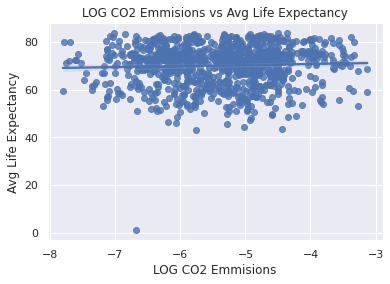

In [30]:
#CO2_life = CO2_capita.merge(life, left_on = 'country_code', right_on = 'country_code')
CO2 = CO2.sample(1000)
CO2['log_CO2'] = np.log(CO2['CO2 density'])
sns.regplot(x="log_CO2", y="avg_life", data=CO2)
plt.xlabel('LOG CO2 Emmisions')
plt.ylabel('Avg Life Expectancy')
plt.title('LOG CO2 Emmisions vs Avg Life Expectancy')

plt.show()

We also wanted to analyze the relationship between CO2 emmisions and average life expectancy. We anticipated there to be a negative correlation between the two because higher CO2 emmisions might be an indicator for pollution which can lead to a variety of respiratory diseases, and hence, a lower life expectancy.

What we observed aligned with our hypothesis. Our analysis showed that there was a slight negative correlation between the two. We anticipate that this correlation is weak because the CO2 emmisions might be correlated to the technological advancements of a given country and thus a indicator for the maturity of the countries underlying infrastructure. And as we observed early, the more developed a country is, the higher the life expectancy of it's given population is expected to me.

We also think the reason why this feature didn't have a strong correlation is because our initial hypothesis might have some truth to it. Meaning that although more developed countries have better health infrastructure in place to support a higher life expectancy, the CO2 emmisions might be causing underly respiratory related complications, and as result, dampening the life expectancy of the population leading to a weak correlation.

### 4. Population Density

In [31]:
%%bigquery --project $project_id pop_density

SELECT t_pop.country_code AS country_code, avg_wdi/year_2018 AS pop_density, t_pop.avg_life AS avg_life
FROM (
    SELECT country_code, year_2018, avg_life
    FROM `cs145-trial.trial1.pop_life` 
) AS t_pop,
(
    SELECT country_code, avg_wdi, avg_life
    FROM `cs145-trial.trial1.wdi_life` 
    WHERE indicator_name = 'Land area (sq. km)'
) AS t_area
WHERE t_pop.country_code = t_area.country_code
GROUP BY t_pop.country_code, avg_wdi, year_2018, t_pop.avg_life

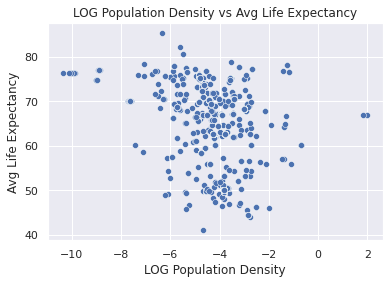

In [32]:
pop_density['log pop_density'] = np.log(pop_density['pop_density'])
sns.scatterplot(x="log pop_density", y="avg_life", data=pop_density)
plt.xlabel('LOG Population Density')
plt.ylabel('Avg Life Expectancy')
plt.title('LOG Population Density vs Avg Life Expectancy')

plt.show()

We wanted to observe the correlation between population density and life expectancy. We had a weak conjecture that the two might have a slight correlation. Our hypothesis was that if a correlation were to exist, it would be a slightly negative correlation because the following: 

*   The land area of a country could be analagous to the amount of available / natural resource a country has.
*   The higher the density of the population in that given area, the fewer resources the country would have that it can allocate on a per capita.
*   Thus, there should ba a negative corelation between the two.

What we observed was within our expectations. We knew our hypothesis was a stretch given how much noise there is in our hypothesis. For example, population density could also be a proxy for urban development, which can be correlated to the technological advancements and health infrastructure of a given country. 

Since there is so much noise in going from population density to life expectancy, we observed that there is no correlation between the two. 


### 5. Undernourished and Breast Feeding

In [33]:
%%bigquery --project $project_id bf_undernourished

SELECT 
    t_bf_multiplier.country_code AS country_code,
    t_bf_multiplier.year AS year,
    breastfeeding_multiplier*avg_wdi AS bf_undernourished,
    avg_life
FROM (
    SELECT
        country_code,
        year,
        CASE 
            WHEN AVG(value) > 60 THEN  0.7
            ELSE 1
        END AS breastfeeding_multiplier
    FROM `bigquery-public-data.world_bank_health_population.health_nutrition_population` 
    WHERE indicator_name = 'Exclusive breastfeeding (% of children under 6 months)'
    GROUP BY country_code, year
    HAVING year BETWEEN 2006 AND 2016
) AS t_bf_multiplier,
(
    SELECT country_code, year, AVG(value) AS avg_wdi
    FROM `bigquery-public-data.world_bank_health_population.health_nutrition_population`
    WHERE indicator_name = 'Prevalence of undernourishment (% of population)'
    GROUP BY country_code, year
    HAVING year BETWEEN 2006 AND 2016
) t_undernourish,
(
    SELECT country_code, year, AVG(value) AS avg_life
    FROM `bigquery-public-data.world_bank_health_population.health_nutrition_population`
    WHERE indicator_name = 'Life expectancy at birth, total (years)'
    GROUP BY country_code, year
    HAVING year BETWEEN 2006 AND 2016
) t_avg_life
WHERE t_bf_multiplier.country_code = t_undernourish.country_code
AND t_bf_multiplier.year = t_avg_life.year
GROUP BY t_bf_multiplier.country_code, year, breastfeeding_multiplier, avg_wdi, avg_life

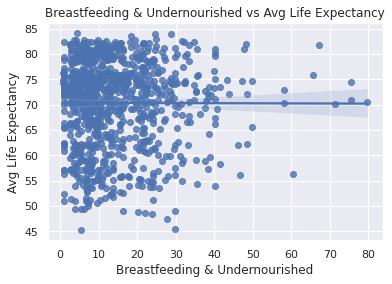

In [34]:
bf_undernourished = bf_undernourished.sample(1000)
sns.regplot(x="bf_undernourished", y="avg_life", data=bf_undernourished)
plt.xlabel('Breastfeeding & Undernourished')
plt.ylabel('Avg Life Expectancy')
plt.title('Breastfeeding & Undernourished vs Avg Life Expectancy')
plt.show()

We also wanted to observe the relationship between the prevalence of undernourishment and exclusive breastfeeding in a given population and life expectancy. We knew that undernourishment has a negative correlation to life expectancy (which makes sense), but we wanted to see if we dampen the undernourishment weight for a population if a population known breastfeed, whether the result will have stronger correlation to the average life expectancy.

Our rationale for dampening the undernourishment was that that breastfed babies are known to be healthier than formula born babies and we wanted to see if this insight can have a impact large enough to make a significant difference in a populations life expectancy.

Our result yielded that the two had a weak negative correlation. This makes sense because undernourishment should have a negative relation with life expectancy but our incorporation of breastfeeding actually made the correlation weaker. We feel that this might be because undernourishment already captures whether a population is breastfeeding or not. Thus our addition of breastfeeding over-dampens the ouput resulting in a weaker correlation.

### 6. Skilled Staff and Maternal Mortality categorical variable

In [35]:
%%bigquery --project $project_id birth_staff_mortality

SELECT t_birth_mortality.country_code AS country_code, CASE
WHEN avg_wdi/mortality_divisor < 0.9 THEN 0
ELSE 1
END AS skilled_mortality, avg_life
FROM (
SELECT country_code, CASE 
WHEN avg_wdi < 60 THEN  1.2
ELSE 1
END AS mortality_divisor, avg_life
FROM `cs145-trial.trial1.wdi_life` 
WHERE indicator_name = 'Births attended by skilled health staff (% of total)'
) AS t_birth_mortality,

(
  SELECT country_code, AVG(value) AS avg_wdi
  FROM `bigquery-public-data.world_bank_health_population.health_nutrition_population` 
  WHERE indicator_name = 'Maternal mortality ratio (national estimate, per 100,000 live births)'
  GROUP BY country_code
) AS t_maternal_mort
WHERE t_birth_mortality.country_code = t_maternal_mort.country_code


Text(0, 0.5, 'avg life expectancy')

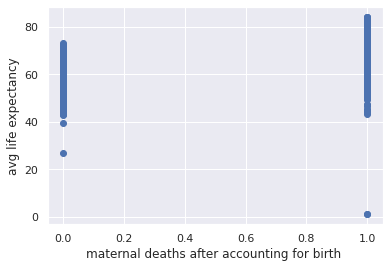

In [36]:
plt.scatter(birth_staff_mortality['skilled_mortality'], birth_staff_mortality['avg_life'])
plt.xlabel('maternal deaths after accounting for birth ')
plt.ylabel('avg life expectancy')

There can be multiple reasons for maternal deaths, such as the care the mother recieved during pregnancy, the general health life of the mother (if the mother regularly used to stay healthy throughout her life), complications during child birth, etc. The last factor, i.e., complications during child birth can put the mother's risk at significant danger even if she's had a healthy life and would have lived a long life if not for pregnancy. Therefore, we tried to factor out this factor to study the health of a mother without looking at the care she recieved during childbirth. 

If a country does not have a skilled birth staff, we hypothesized that the chances of a pregnant women dying are more as compared to a women who benefitted from proper birth care. Therefore, we divided the maternal mortality rate by a factor greater than 1 for countries that do not have adequate skilled health staff for birth. This accounts for the inflation in maternal deaths solely due to the mother not recieving proper care. This gives us an indicator of the health of mothers. As the health of mothers has a strong correlation to the health of a child as well, we expected this indicator to influence the life expectancy of the mother as well as the child.
We decided to make this indicator categorical by dividing it on the basis

### 7. Education Expenditure GDP

In [37]:
%%bigquery --project $project_id education_expenditure

SELECT t_gdp.country_code AS country_code, t_gdp.year AS year, govt_expenditure*gdp as gdp_norm, t_gdp.avg_life AS avg_life
FROM (
    SELECT country_code, year, AVG(value) AS govt_expenditure
    FROM bigquery-public-data.world_bank_wdi.indicators_data 
    WHERE indicator_name = 'Government expenditure on education, total (% of GDP)'
    GROUP BY country_code, year
) AS t_govt_exp,
(
    SELECT country_code, year, avg_wdi AS gdp, avg_life
    FROM cs145-trial.trial1.wdi_life
    WHERE indicator_name = 'GDP (current US$)'
) AS t_gdp
WHERE t_govt_exp.country_code = t_gdp.country_code
    AND t_govt_exp.year = t_gdp.year
    AND t_govt_exp.year BETWEEN 2006 AND 2016

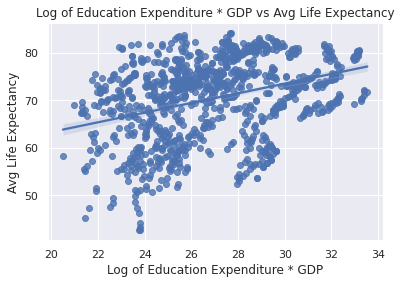

In [38]:
education_expenditure = education_expenditure.sample(1000)
education_expenditure['log gdp_norm'] = np.log(education_expenditure['gdp_norm'] + 0.0001)
sns.regplot(x="log gdp_norm", y="avg_life", data=education_expenditure)
plt.xlabel('Log of Education Expenditure * GDP')
plt.ylabel('Avg Life Expectancy')
plt.title('Log of Education Expenditure * GDP vs Avg Life Expectancy')
plt.show()

We observed earlier that education expenditure % is correlated to life expectancy because of the following reasons:  

*   Heavily investing in education is normally an indicator of a progressive and affluent nation. Normally for low-income and developing nations, education doesn't make the cut and these countries have lower life expectancies than the former developed nations. 
*   Investing in education can also be a delayed indicator of technological advancements in that country. The better the education, the more cutting edge research is being done in that country and as a result, the better the health care in that country.

What we wanted to do was create a stronger feature my multiplying the education expenditure % by the gdp of the country to calculate the raw amount a country invests in education.

Our rationale behind this was that even if a country invests majority of its wealth in education, it might not be a lot of money if the country's GDP is low. We wanted to reduce this noise by multiplying the two. 

Our results yielded that there was a positive correlation between our feature and life expectancy which was expected.



### 8. Physicians and Beds

In [39]:
%%bigquery --project $project_id phys_bed

SELECT t_phys.country_code AS country_code, t_phys.year, phys*bed AS phys_bed, avg_life
FROM(
    SELECT country_code, year, avg_wdi AS phys, avg_life
    FROM `cs145-trial.trial1.wdi_life`
    WHERE indicator_name = 'Physicians (per 1,000 people)'
) AS t_phys,
(
    SELECT country_code, year, avg_wdi AS bed
    FROM `cs145-trial.trial1.wdi_life`
    WHERE indicator_name = 'Hospital beds (per 1,000 people)'
) AS t_bed
WHERE t_phys.country_code = t_bed.country_code
    AND t_phys.year = t_bed.year
    AND t_phys.year BETWEEN 2006 AND 2016

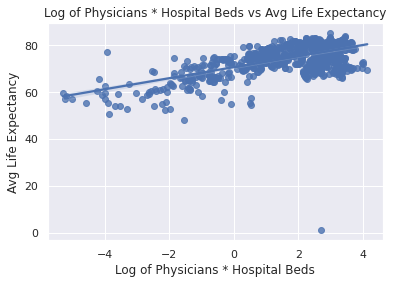

In [40]:
phys_bed = phys_bed.sample(1000)
phys_bed['log phys_bed'] = np.log(phys_bed['phys_bed'])
sns.regplot(x = "log phys_bed", y = "avg_life", data=phys_bed)
plt.xlabel('Log of Physicians * Hospital Beds')
plt.ylabel('Avg Life Expectancy')
plt.title('Log of Physicians * Hospital Beds vs Avg Life Expectancy')
plt.show()

A few indicators we were ruminating on were the number of physicians and the number of hospital beds. Both of them were loosely positively correlated to life expectancy for a given country for obvious reasons (both are proxies for the maturity of the country’s healthcare infrastructure). We postulated that combining the two would be a better feature for life expectancy because of the following: 

- A country with a lot of doctors without the corresponding investment in hospital beds we hypothesize will probably not have a high life expectancy because the doctors are not equipped with the proper medical infrastructure to help the patients to their fullest capacity.
- A country with a lot of beds without doctors will also most likely have a low life expectancy because although the country has invested significant resources, there is no one who knows how to utilize them properly to improve the life expectancy in that country.

We decided to multiply the two together to eliminate these edge cases. The result was that following engineered feature has a strong positive correlation to the life expectancy at a given country.

### 9. Diarrhea water

In [41]:
%%bigquery --project $project_id diarrhea

SELECT t_diarrhea.country_code AS country_code, t_diarrhea.year, diarrhea/basic_water AS diar_water, avg_life
FROM (
    SELECT country_code, year, AVG(value) AS diarrhea
    FROM `bigquery-public-data.world_bank_health_population.health_nutrition_population` 
    WHERE indicator_name = 'Diarrhea treatment (% of children under 5 who received ORS packet)'
    GROUP BY country_code, year
    HAVING year BETWEEN 2006 AND 2016
) AS t_diarrhea,
(
    SELECT country_code, year, avg_wdi AS basic_water, avg_life
    FROM `cs145-trial.trial1.wdi_life`
    WHERE indicator_name = 'People using at least basic drinking water services (% of population)'
) AS t_basic_water
WHERE t_diarrhea.country_code = t_basic_water.country_code
    AND t_diarrhea.year = t_basic_water.year

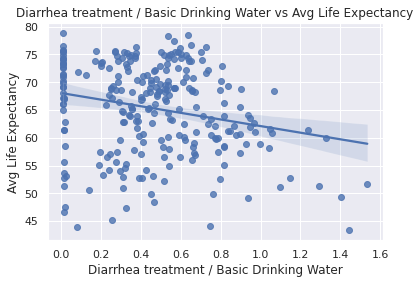

In [42]:
sns.regplot(x = "diar_water", y = "avg_life", data=diarrhea)
plt.xlabel('Diarrhea treatment / Basic Drinking Water')
plt.ylabel('Avg Life Expectancy')
plt.title('Diarrhea treatment / Basic Drinking Water vs Avg Life Expectancy')
plt.show()

We also wanted to explore if there was any correlation between normalizing the incidence of diarrhea by basic drinking water services and life expectancy. The hypothesis here was the by normalizing the incidence of diarrhea by basic drinking water services, we will reduce the weight of countries that have a high incidence rate of diarrhea but proper sanitation services so the diarrhea is not a concern, and increase the weightage of diarrhea in countries without proper sanitation infrastructure where diarrhea might be more of a concern.

Unfortunately, our hypothesis was incorrect — there was slight negative to no correlation to life expectancy. We think that this might be due to the fact that diarrhea is rarely fatal and doesn't affect the bottom line of life expectancy in most cases. However, we were right about the most extreme cases (lots of diarrhea and lack of basic drinking water) has a very low life expectancy but there is still too much noise in rest of the data.

### 10. Beds and expenditure

In [43]:
%%bigquery --project $project_id beds_expenditure

SELECT t_expend.country_code AS country_code, expend / bed AS bed_expend, avg_life
FROM(
    SELECT country_code, year, avg_health AS expend, avg_life
    FROM `cs145-trial.trial1.health_life_2`
    WHERE indicator_name = 'Domestic general government health expenditure (% of general government expenditure)'
    AND year BETWEEN 2006 AND 2016
) AS t_expend,
(
    SELECT country_code, year, avg_wdi AS bed
    FROM `cs145-trial.trial1.wdi_life`
    WHERE indicator_name = 'Hospital beds (per 1,000 people)'
    AND year BETWEEN 2006 AND 2016
) AS t_bed
WHERE t_expend.country_code = t_bed.country_code
    AND t_expend.year = t_bed.year

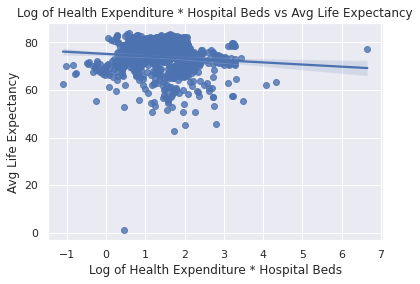

In [44]:
beds_expenditure = beds_expenditure.sample(1000)
beds_expenditure['log bed_expend'] = np.log(beds_expenditure['bed_expend']+0.0001)
sns.regplot(x = "log bed_expend", y = "avg_life", data = beds_expenditure)
plt.xlabel('Log of Health Expenditure * Hospital Beds')
plt.ylabel('Avg Life Expectancy')
plt.title('Log of Health Expenditure * Hospital Beds vs Avg Life Expectancy')
plt.show()

We wanted to understand how good the health infrastructure in a country is. Poor quality of service in a larger quantity doesn't necessarily provide health benefits to the citizens, as the poor quality services might not be able to save lives or provide critical healthcare. We factor this as follows - 


* We normalized the number of hospital beds in a country with the government 
* This normalization measures how much money is being spent on each bed, which can be used as a proxy for how good is each individual resource that the government is providing.

To our surprise, we found a weak negative correlation between beds/expenditure and life expectancy. This means that governments spending more money on hospital beds would not improve the health situation. This indicates that other health facilities instead of hospital beds are more critically related to improving the health services in a country. 

### 11. Immunization by population change 

In [45]:
%%bigquery --project $project_id immunization_pop

SELECT country_code, indicator_name, AVG(value) AS avg_immunization
 FROM `bigquery-public-data.world_bank_health_population.health_nutrition_population` 
 WHERE indicator_name IN (SELECT * FROM `cs145-trial.trial1.immunizations`)
 AND year BETWEEN 2014 AND 2018
 GROUP BY country_code, indicator_name

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

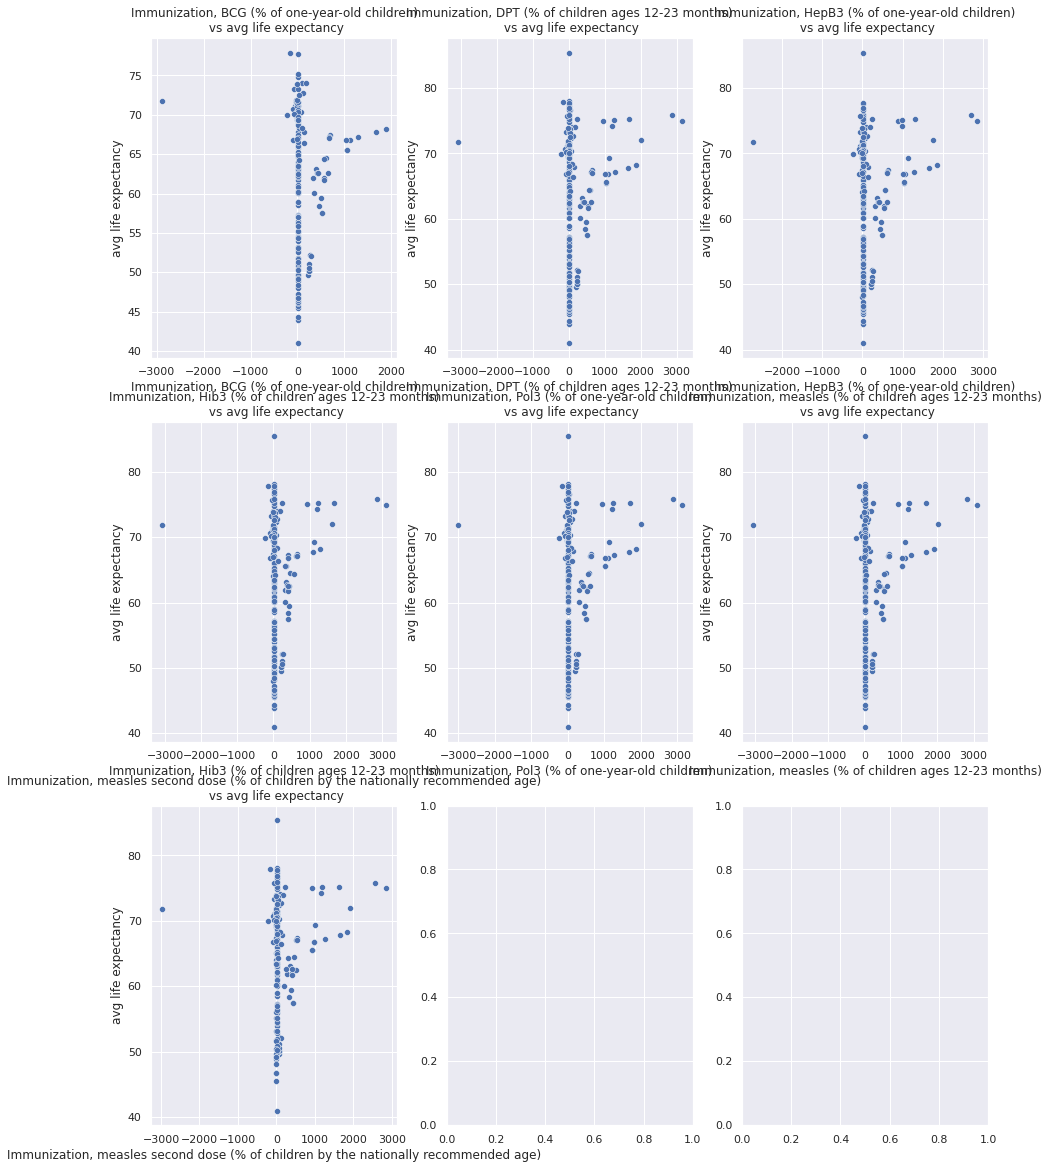

In [47]:
immunization_and_pop = immunization_pop.merge(pop_rate_change, left_on='country_code', right_on = 'country_code')
indics = np.unique(immunization_pop['indicator_name'])

import seaborn as sns; sns.set_theme(color_codes=True)
columns = 3
rows = 3
fig, axs = plt.subplots(nrows=rows,ncols=columns, figsize=(15,20))

for count, indic in enumerate(indics):
  indic_df = immunization_and_pop[immunization_and_pop['indicator_name'] == indic]
  if indic_df.shape[0] > 1000:
    indic_df = indic_df.sample(1000)
  indic_df['immunization_rate'] = indic_df['avg_immunization']/indic_df['rate_change']
  sns.scatterplot(x='immunization_rate', y='avg_life', data=indic_df, ax=axs[count//columns][count%columns])
  axs[count//columns][count%columns].set_xlabel(indic)
  axs[count//columns][count%columns].set_ylabel('avg life expectancy')
  axs[count//columns][count%columns].set_title(indic+'\n vs avg life expectancy')
plt.show()

We hypothesize that countries with a higher growth rate need to immunize more people to improve the health of the nation. We explain our reasoning below. 


* If the population of a country is increasing, then just immunizing more people is not a sign of improvement as the fraction of people immunized might still be low for that country.
* We consider an increase in immunization to be an improvement if more fraction of people are immunized in a country, which would improve the life expectancy of a greater fraction of people.

To factor in the growth of population, we divide the percentage of population immunized in a country by the population growth rate. This normalizes the increasing immunization by the increasing population.

Unfortunately, immunization graphs are heavily skewed towards 0 as a lot of countries do not provide vaccinations. Of the non-zero values, there's a clear positve correlation to life expectancy as vaccines make people immune to potentially deadly diseases.



### 12. Undernourish times spending 

In [48]:
%%bigquery --project $project_id stunting_undernourishment

SELECT 
    T_stunting.country_code AS country_code,
    T_stunting.year,
    T_stunting.avg_life AS avg_life,
    T_stunting.stunting * undernourishment AS stunting_undernourishment
FROM (
    SELECT
        country_code,
        year,
        AVG(avg_life) AS avg_life,
        AVG(avg_health) AS stunting
    FROM `cs145-trial.trial1.health_life_2`
    WHERE indicator_name = 'Prevalence of stunting, height for age (modeled estimate, % of children under 5)'
    GROUP BY country_code, year
    HAVING year BETWEEN 2006 AND 2016
) AS T_stunting,
(
    SELECT
        country_code,
        year,
        AVG(avg_health) AS undernourishment
    FROM `cs145-trial.trial1.health_life_2`
    WHERE indicator_name = 'Prevalence of undernourishment (% of population)'
    GROUP BY country_code, year
    HAVING year BETWEEN 2006 AND 2016
) AS T_undernourishment
WHERE T_stunting.country_code = T_undernourishment.country_code 
    AND T_stunting.year = T_undernourishment.year

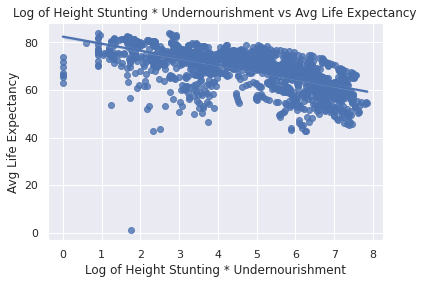

In [49]:
stunting_undernourishment['log stunting_undernourishment'] = np.log(stunting_undernourishment['stunting_undernourishment'])
sns.regplot(x="log stunting_undernourishment", y="avg_life", data=stunting_undernourishment)
plt.xlabel('Log of Height Stunting * Undernourishment')
plt.ylabel('Avg Life Expectancy')
plt.title('Log of Height Stunting * Undernourishment vs Avg Life Expectancy')
plt.show()

We found both undernourishment and stunting to be strong indicators of low life expectancy. This makes sense as both indicators are signs of poor health conditions, and make people suffering from them to be susceptible to an early death. We hypothesized that multiplying these indicators would increase the overall dependence on life expectancy. Multiplying the two indicators showed a strong non-linear relationship to the target, indicating that the individual factors are linearly related to life expectancy. Therefore, we decided to use the lof of the multiplication to capture the product as a linear combination of logs as each individual indicator is related to the target.

An additional information that the product captures is how much of stunting is because of undernourishment. There can be multiple reasons for stunting, including but not limited to hormonal imbalance, poor diet, environmental factors, etc. If we imagine the value of stunting to be a linear weighted sum of these factors, then multiplying stunting by undernourishment pushes countries with more cases of stunting due to undernourishment to a larger value as these countries will also exhibit a larger value for undernourishment.

### 13. GDP / Undernourishment

In [50]:
%%bigquery --project $project_id gdp_undernourishment


SELECT 
    T_undernourishment.country_code AS country_code,
    T_undernourishment.year,
    T_undernourishment.avg_life AS avg_life,
    T_gdp.gdp_per_capita  / T_undernourishment.undernourishment AS gdp_undernourishment
FROM (
    SELECT
        country_code,
        year,
        AVG(avg_life) AS avg_life,
        AVG(avg_health) AS undernourishment
    FROM `cs145-trial.trial1.health_life_2`
    WHERE indicator_name = 'Prevalence of undernourishment (% of population)'
    GROUP BY country_code, year
    HAVING year BETWEEN 2006 AND 2016
) AS T_undernourishment,
(
    SELECT
        country_code,
        year,
        AVG(value) AS gdp_per_capita
    FROM `bigquery-public-data.world_bank_wdi.indicators_data`
    WHERE indicator_name = 'GDP per capita (current US$)'
    GROUP BY country_code, year
    HAVING year BETWEEN 2006 AND 2016
) AS T_gdp
WHERE T_undernourishment.country_code = T_gdp.country_code 
    AND T_undernourishment.year = T_gdp.year


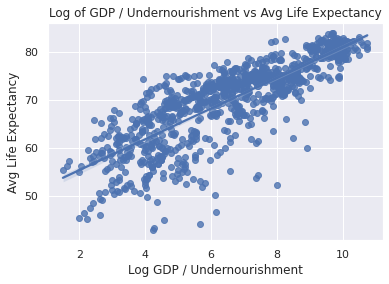

In [51]:
gdp_undernourishment = gdp_undernourishment.sample(1000)
gdp_undernourishment['log gdp_undernourishment'] = np.log(gdp_undernourishment['gdp_undernourishment']+0.0001)
sns.regplot(x="log gdp_undernourishment", y="avg_life", data=gdp_undernourishment)
plt.xlabel('Log GDP / Undernourishment')
plt.ylabel('Avg Life Expectancy')
plt.title('Log of GDP / Undernourishment vs Avg Life Expectancy')
plt.show()

Although Height Stunting and Undernourishment weren't as strongly correlated as we would have hoped, it fueled another idea. We then thought of normalizing the Country's GDP by undernourishment. Our rationale behind this was that although some countries may have a high GDP, it doesn't (from a life expectancy standpoint) mean much if it's poorly utilized. Thus by normalizing the GDP by undernourishment prevalence, we expect to deflate the values of countries with high GDP but poor investment in public infrastructure.

Our hypothesis was farily accurate. We observed a very strong positive correlation between normalizing the GDP with Undernourishment and Life Expectancy.

### 14. Internet & Secondary School Enrollment

In [52]:
%%bigquery --project $project_id internet_secondary

SELECT 
    t_internet.country_code AS country_code,
    t_internet.year AS year,
    internet_users*secondary AS internet_secondary,
    avg_life
FROM (
    SELECT 
        country_code,
        year,
        AVG(value) AS internet_users
    FROM `bigquery-public-data.world_bank_intl_education.international_education` 
    WHERE indicator_name = 'Internet users (per 100 people)'
    GROUP BY country_code, year
    HAVING year BETWEEN 2006 AND 2016
) AS t_internet,
(
    SELECT country_code, year, AVG(value) AS secondary
    FROM `bigquery-public-data.world_bank_intl_education.international_education`
    WHERE indicator_name = 'Gross enrolment ratio, secondary, both sexes (%)'
    GROUP BY country_code, year
    HAVING year BETWEEN 2006 AND 2016
) t_secondary,
(
    SELECT
        country_code,
        year,
        AVG(avg_life) AS avg_life
    FROM `cs145-trial.trial1.health_life_2`
    GROUP BY country_code, year
    HAVING year BETWEEN 2006 AND 2016
) AS t_life
WHERE t_internet.country_code = t_secondary.country_code
    AND t_internet.country_code = t_life.country_code
    AND t_internet.year = t_secondary.year
    AND t_internet.year = t_life.year
    AND internet_users*secondary != 0

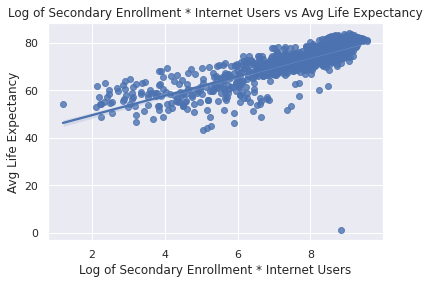

In [53]:
internet_secondary = internet_secondary.sample(1000)
internet_secondary['log internet_secondary'] = np.log(internet_secondary['internet_secondary']+0.0001)
sns.regplot(x="log internet_secondary", y="avg_life", data=internet_secondary)
plt.xlabel('Log of Secondary Enrollment * Internet Users')
plt.ylabel('Avg Life Expectancy')
plt.title('Log of Secondary Enrollment * Internet Users vs Avg Life Expectancy')
plt.show()

Lastly, we had a hypothesis that multiplying the prevalence of internet and the secondary education enrollment rate at a given country would be a strong positive indicator of life expectancy because of the following 

*   We already know that secondary education enrollment rate is positively correlated to life expectancy for reasons mentioned above.
*   Internet users is also weakly correlated to life expectancy because it's a proxy for the technological advancement and affluence of the given country. And normally, the more affluent the country, the more money it can allocate per capita for it's given health infratstructure. Thus the weak correlation.

We decided the multiply the two together as a proxy development of the education infrastructure at a given country. Our hypothesis ended up being correct and we did observe a strong positive correlation between our engineered feature and life expectancy.

## Data Prediction

A signifcant portion of the older data a null values which increased the noise in our model. As a result, we decided to split up our data in the following way: 

*   **Training Set**: Dates ranging from 2006 to 2012
*   **Evaluation Set**: Dates ranging from 2013 to 2014
*   **Test Set**: Dates ranging from 2015 to 2016

We wanted to reserve most of data for training and we used equal amounts of data for both testing and training.

In [54]:
model_dataset_name = 'bqml_life_expectancy'

dataset = bigquery.Dataset(client.dataset(model_dataset_name))
dataset.location = 'US'
client.create_dataset(dataset)

**Training the Model with Skilled Staff and Maternal Mortality categorical variable**

In [55]:
%%bigquery --project $project_id

CREATE OR REPLACE MODEL `bqml_life_expectancy.life_expectancy_model`
OPTIONS(model_type='logistic_reg') AS
WITH life_expec AS (
    SELECT
        country_code,
        year,
        CASE
            WHEN AVG(value) < 68 THEN 'early_age'
            WHEN AVG(value) >= 68 AND AVG(value) < 75 THEN 'middle_age'
            ELSE 'old_age'
        END AS life_expec_bucket
    FROM `bigquery-public-data.world_bank_health_population.health_nutrition_population`
    WHERE indicator_name = 'Life expectancy at birth, total (years)'
    GROUP BY country_code, year
),
pri_sec_ratio_life AS (
    SELECT 
        T_primary.country_code AS country_code,
        T_primary.year,
        CASE
            WHEN secondary = 0 THEN 0
            ELSE primary / secondary
        END AS pri_sec_ratio
    FROM (
        SELECT country_code, year, AVG(value) AS primary
        FROM `bigquery-public-data.world_bank_intl_education.international_education` 
        WHERE indicator_name = 'Enrolment in primary education, female (number)'
        GROUP BY country_code, year
    ) AS T_primary,
    (
        SELECT country_code, year, AVG(value) AS secondary
        FROM `bigquery-public-data.world_bank_intl_education.international_education` 
        WHERE indicator_name = 'Enrolment in secondary education, female (number)'
        GROUP BY country_code, year
    ) AS T_secondary
    WHERE T_primary.country_code = T_secondary.country_code
        AND T_primary.year = T_secondary.year
),
bf_undernourished AS (
    SELECT 
        t_bf_multiplier.country_code AS country_code,
        breastfeeding_multiplier*avg_wdi AS bf_undernourished,
    FROM (
        SELECT country_code,
            CASE 
                WHEN AVG(value) > 60 THEN 0.7
                ELSE 1
            END
            AS breastfeeding_multiplier
        FROM `bigquery-public-data.world_bank_health_population.health_nutrition_population`
        WHERE indicator_name = 'Exclusive breastfeeding (% of children under 6 months)'
          AND year < 2013 AND year > 2005
        GROUP BY country_code
    ) AS t_bf_multiplier,
    (
        SELECT country_code, AVG(value) AS avg_wdi
        FROM `bigquery-public-data.world_bank_health_population.health_nutrition_population`
        WHERE indicator_name = 'Prevalence of undernourishment (% of population)'
          AND year < 2013 AND year > 2005
        GROUP BY country_code
    ) t_undernourish
    WHERE t_bf_multiplier.country_code = t_undernourish.country_code
    GROUP BY t_bf_multiplier.country_code, breastfeeding_multiplier, avg_wdi
),
phys_bed AS (
    SELECT t_phys.country_code AS country_code, t_phys.year AS year, phys*bed AS phys_bed
    FROM (
        SELECT country_code, year, avg_wdi AS phys
        FROM `cs145-trial.trial1.wdi_life`
        WHERE indicator_name = 'Physicians (per 1,000 people)'
    ) AS t_phys,
    (
        SELECT country_code, year, avg_wdi AS bed
        FROM `cs145-trial.trial1.wdi_life`
        WHERE indicator_name = 'Hospital beds (per 1,000 people)'
    ) AS t_bed
    WHERE t_phys.country_code = t_bed.country_code
),
anemia AS (
    SELECT
        country_code,
        year,
        AVG(value) AS chance_of_anemia
    FROM `bigquery-public-data.world_bank_health_population.health_nutrition_population`
    WHERE indicator_name = 'Prevalence of anemia among children (% of children ages 6-59 months)'
    GROUP BY country_code, year
),
gdp_undernourishment AS (
    SELECT 
        T_undernourishment.country_code AS country_code,
        T_undernourishment.year,
        T_gdp.gdp_per_capita  / T_undernourishment.undernourishment AS gdp_undernourishment
    FROM (
        SELECT
            country_code,
            year,
            AVG(avg_health) AS undernourishment
        FROM `cs145-trial.trial1.health_life_2`
        WHERE indicator_name = 'Prevalence of undernourishment (% of population)'
        GROUP BY country_code, year
    ) AS T_undernourishment,
    (
        SELECT
            country_code,
            year,
            AVG(value) AS gdp_per_capita
        FROM `bigquery-public-data.world_bank_wdi.indicators_data`
        WHERE indicator_name = 'GDP per capita (current US$)'
        GROUP BY country_code, year
    ) AS T_gdp
    WHERE T_undernourishment.country_code = T_gdp.country_code 
        AND T_undernourishment.year = T_gdp.year
),
internet_secondary AS (
    SELECT 
        t_internet.country_code AS country_code,
        t_internet.year AS year,
        internet_users*secondary AS internet_secondary,
    FROM (
        SELECT 
            country_code,
            year,
            AVG(value) AS internet_users
        FROM `bigquery-public-data.world_bank_intl_education.international_education` 
        WHERE indicator_name = 'Internet users (per 100 people)'
        GROUP BY country_code, year
    ) AS t_internet,
    (
      SELECT country_code, year, AVG(value) AS secondary
      FROM `bigquery-public-data.world_bank_intl_education.international_education`
      WHERE indicator_name = 'Gross enrolment ratio, secondary, both sexes (%)'
      GROUP BY country_code, year
    ) t_secondary
    WHERE t_internet.country_code = t_secondary.country_code
        AND t_internet.year = t_secondary.year
),
skilled_mat_mortality AS (
    SELECT 
        t_birth_mortality.country_code AS country_code,
        t_birth_mortality.year AS year,
        CASE
            WHEN avg_wdi/mortality_divisor < 0.9 THEN 0
            ELSE 1
        END AS skilled_mortality
    FROM (
        SELECT 
            country_code,
            year,
            CASE 
                WHEN avg_wdi < 60 THEN  1.2
                ELSE 1
            END AS mortality_divisor
        FROM `cs145-trial.trial1.wdi_life` 
        WHERE indicator_name = 'Births attended by skilled health staff (% of total)'
    ) AS t_birth_mortality,
    (
        SELECT country_code, year, AVG(value) AS avg_wdi
        FROM `bigquery-public-data.world_bank_health_population.health_nutrition_population` 
        WHERE indicator_name = 'Maternal mortality ratio (national estimate, per 100,000 live births)'
        GROUP BY country_code, year
    ) AS t_maternal_mort
    WHERE t_birth_mortality.country_code = t_maternal_mort.country_code
        AND t_birth_mortality.year = t_maternal_mort.year
)

SELECT pri_sec_ratio,
    bf_undernourished.bf_undernourished,
    phys_bed.phys_bed, 
    anemia.chance_of_anemia,
    gdp_undernourishment.gdp_undernourishment,
    internet_secondary.internet_secondary,
    life_expec_bucket AS label
FROM life_expec
LEFT JOIN pri_sec_ratio_life
    ON life_expec.country_code = pri_sec_ratio_life.country_code
    AND life_expec.year = pri_sec_ratio_life.year
LEFT JOIN bf_undernourished
    ON life_expec.country_code = bf_undernourished.country_code
LEFT JOIN phys_bed
    ON life_expec.country_code = phys_bed.country_code
    AND life_expec.year = phys_bed.year
LEFT JOIN anemia
    ON life_expec.country_code = anemia.country_code
    AND life_expec.year = anemia.year
LEFT JOIN gdp_undernourishment
    ON life_expec.country_code = gdp_undernourishment.country_code
    AND life_expec.year = gdp_undernourishment.year
LEFT JOIN internet_secondary
    ON life_expec.country_code = internet_secondary.country_code
    AND life_expec.year = internet_secondary.year
LEFT JOIN skilled_mat_mortality
    ON life_expec.country_code = skilled_mat_mortality.country_code
    AND life_expec.year = skilled_mat_mortality.year
WHERE life_expec.year BETWEEN 2006 AND 2012
ORDER BY label

Empty DataFrame
Columns: []
Index: []

In [56]:
%%bigquery --project $project_id

# Run cell to view training stats

SELECT
  *
FROM
  ML.TRAINING_INFO(MODEL `bqml_life_expectancy.life_expectancy_model`)

training_run  iteration      loss  eval_loss  learning_rate  duration_ms
0             0          7  0.176661   0.175691            3.2         7183
1             0          6  0.177746   0.177106           12.8         7003
2             0          5  0.181280   0.180673            6.4         6992
3             0          4  0.191057   0.191153            3.2         8838
4             0          3  0.209958   0.210505            1.6        12367
5             0          2  0.241539   0.242143            0.8         7369
6             0          1  0.285751   0.286102            0.4         5968
7             0          0  0.331696   0.331801            0.2         4522

**Evaluating the Model with Skilled Staff and Maternal Mortality categorical variable**

In [57]:
%%bigquery --project $project_id

SELECT
  *
FROM
  ML.EVALUATE(MODEL `bqml_life_expectancy.life_expectancy_model`, (
WITH life_expec AS (
    SELECT
        country_code,
        year,
        CASE
            WHEN AVG(value) < 68 THEN 'early_age'
            WHEN AVG(value) >= 68 AND AVG(value) < 75 THEN 'middle_age'
            ELSE 'old_age'
        END AS life_expec_bucket
    FROM `bigquery-public-data.world_bank_health_population.health_nutrition_population`
    WHERE indicator_name = 'Life expectancy at birth, total (years)'
    GROUP BY country_code, year
),
pri_sec_ratio_life AS (
    SELECT 
        T_primary.country_code AS country_code,
        T_primary.year,
        CASE
            WHEN secondary = 0 THEN 0
            ELSE primary / secondary
        END AS pri_sec_ratio
    FROM (
        SELECT country_code, year, AVG(value) AS primary
        FROM `bigquery-public-data.world_bank_intl_education.international_education` 
        WHERE indicator_name = 'Enrolment in primary education, female (number)'
        GROUP BY country_code, year
    ) AS T_primary,
    (
        SELECT country_code, year, AVG(value) AS secondary
        FROM `bigquery-public-data.world_bank_intl_education.international_education` 
        WHERE indicator_name = 'Enrolment in secondary education, female (number)'
        GROUP BY country_code, year
    ) AS T_secondary
    WHERE T_primary.country_code = T_secondary.country_code
        AND T_primary.year = T_secondary.year
),
bf_undernourished AS (
    SELECT 
        t_bf_multiplier.country_code AS country_code,
        breastfeeding_multiplier*avg_wdi AS bf_undernourished,
    FROM (
        SELECT country_code,
            CASE 
                WHEN AVG(value) > 60 THEN 0.7
                ELSE 1
            END
            AS breastfeeding_multiplier
        FROM `bigquery-public-data.world_bank_health_population.health_nutrition_population`
        WHERE indicator_name = 'Exclusive breastfeeding (% of children under 6 months)'
          AND year < 2013 AND year > 2005
        GROUP BY country_code
    ) AS t_bf_multiplier,
    (
        SELECT country_code, AVG(value) AS avg_wdi
        FROM `bigquery-public-data.world_bank_health_population.health_nutrition_population`
        WHERE indicator_name = 'Prevalence of undernourishment (% of population)'
          AND year < 2013 AND year > 2005
        GROUP BY country_code
    ) t_undernourish
    WHERE t_bf_multiplier.country_code = t_undernourish.country_code
    GROUP BY t_bf_multiplier.country_code, breastfeeding_multiplier, avg_wdi
),
phys_bed AS (
    SELECT t_phys.country_code AS country_code, t_phys.year AS year, phys*bed AS phys_bed
    FROM (
        SELECT country_code, year, avg_wdi AS phys
        FROM `cs145-trial.trial1.wdi_life`
        WHERE indicator_name = 'Physicians (per 1,000 people)'
    ) AS t_phys,
    (
        SELECT country_code, year, avg_wdi AS bed
        FROM `cs145-trial.trial1.wdi_life`
        WHERE indicator_name = 'Hospital beds (per 1,000 people)'
    ) AS t_bed
    WHERE t_phys.country_code = t_bed.country_code
),
anemia AS (
    SELECT
        country_code,
        year,
        AVG(value) AS chance_of_anemia
    FROM `bigquery-public-data.world_bank_health_population.health_nutrition_population`
    WHERE indicator_name = 'Prevalence of anemia among children (% of children ages 6-59 months)'
    GROUP BY country_code, year
),
gdp_undernourishment AS (
    SELECT 
        T_undernourishment.country_code AS country_code,
        T_undernourishment.year,
        T_gdp.gdp_per_capita  / T_undernourishment.undernourishment AS gdp_undernourishment
    FROM (
        SELECT
            country_code,
            year,
            AVG(avg_health) AS undernourishment
        FROM `cs145-trial.trial1.health_life_2`
        WHERE indicator_name = 'Prevalence of undernourishment (% of population)'
        GROUP BY country_code, year
    ) AS T_undernourishment,
    (
        SELECT
            country_code,
            year,
            AVG(value) AS gdp_per_capita
        FROM `bigquery-public-data.world_bank_wdi.indicators_data`
        WHERE indicator_name = 'GDP per capita (current US$)'
        GROUP BY country_code, year
    ) AS T_gdp
    WHERE T_undernourishment.country_code = T_gdp.country_code 
        AND T_undernourishment.year = T_gdp.year
),
internet_secondary AS (
    SELECT 
        t_internet.country_code AS country_code,
        t_internet.year AS year,
        internet_users*secondary AS internet_secondary,
    FROM (
        SELECT 
            country_code,
            year,
            AVG(value) AS internet_users
        FROM `bigquery-public-data.world_bank_intl_education.international_education` 
        WHERE indicator_name = 'Internet users (per 100 people)'
        GROUP BY country_code, year
    ) AS t_internet,
    (
      SELECT country_code, year, AVG(value) AS secondary
      FROM `bigquery-public-data.world_bank_intl_education.international_education`
      WHERE indicator_name = 'Gross enrolment ratio, secondary, both sexes (%)'
      GROUP BY country_code, year
    ) t_secondary
    WHERE t_internet.country_code = t_secondary.country_code
        AND t_internet.year = t_secondary.year
),
skilled_mat_mortality AS (
    SELECT 
        t_birth_mortality.country_code AS country_code,
        t_birth_mortality.year AS year,
        CASE
            WHEN avg_wdi/mortality_divisor < 0.9 THEN 0
            ELSE 1
        END AS skilled_mortality
    FROM (
        SELECT 
            country_code,
            year,
            CASE 
                WHEN avg_wdi < 60 THEN  1.2
                ELSE 1
            END AS mortality_divisor
        FROM `cs145-trial.trial1.wdi_life` 
        WHERE indicator_name = 'Births attended by skilled health staff (% of total)'
    ) AS t_birth_mortality,
    (
        SELECT country_code, year, AVG(value) AS avg_wdi
        FROM `bigquery-public-data.world_bank_health_population.health_nutrition_population` 
        WHERE indicator_name = 'Maternal mortality ratio (national estimate, per 100,000 live births)'
        GROUP BY country_code, year
    ) AS t_maternal_mort
    WHERE t_birth_mortality.country_code = t_maternal_mort.country_code
        AND t_birth_mortality.year = t_maternal_mort.year
)

SELECT pri_sec_ratio,
    bf_undernourished.bf_undernourished,
    phys_bed.phys_bed, 
    anemia.chance_of_anemia,
    gdp_undernourishment.gdp_undernourishment,
    internet_secondary.internet_secondary,
    life_expec_bucket AS label
FROM life_expec
LEFT JOIN pri_sec_ratio_life
    ON life_expec.country_code = pri_sec_ratio_life.country_code
    AND life_expec.year = pri_sec_ratio_life.year
LEFT JOIN bf_undernourished
    ON life_expec.country_code = bf_undernourished.country_code
LEFT JOIN phys_bed
    ON life_expec.country_code = phys_bed.country_code
    AND life_expec.year = phys_bed.year
LEFT JOIN anemia
    ON life_expec.country_code = anemia.country_code
    AND life_expec.year = anemia.year
LEFT JOIN gdp_undernourishment
    ON life_expec.country_code = gdp_undernourishment.country_code
    AND life_expec.year = gdp_undernourishment.year
LEFT JOIN internet_secondary
    ON life_expec.country_code = internet_secondary.country_code
    AND life_expec.year = internet_secondary.year
LEFT JOIN skilled_mat_mortality
    ON life_expec.country_code = skilled_mat_mortality.country_code
    AND life_expec.year = skilled_mat_mortality.year
WHERE life_expec.year BETWEEN 2006 AND 2012
ORDER BY label
))

precision   recall  accuracy  f1_score  log_loss   roc_auc
0   0.815623  0.76495   0.79256  0.784764   0.60975  0.903573

**Training Model without Skilled Staff and Maternal Mortality categorical variable**

In [58]:
%%bigquery --project $project_id

CREATE OR REPLACE MODEL `bqml_life_expectancy.life_expectancy_model`
OPTIONS(model_type='logistic_reg') AS
WITH life_expec AS (
    SELECT
        country_code,
        year,
        CASE
            WHEN AVG(value) < 68 THEN 'early_age'
            WHEN AVG(value) >= 68 AND AVG(value) < 75 THEN 'middle_age'
            ELSE 'old_age'
        END AS life_expec_bucket
    FROM `bigquery-public-data.world_bank_health_population.health_nutrition_population`
    WHERE indicator_name = 'Life expectancy at birth, total (years)'
    GROUP BY country_code, year
),
pri_sec_ratio_life AS (
    SELECT 
        T_primary.country_code AS country_code,
        T_primary.year,
        CASE
            WHEN secondary = 0 THEN 0
            ELSE primary / secondary
        END AS pri_sec_ratio
    FROM (
        SELECT country_code, year, AVG(value) AS primary
        FROM `bigquery-public-data.world_bank_intl_education.international_education` 
        WHERE indicator_name = 'Enrolment in primary education, female (number)'
        GROUP BY country_code, year
    ) AS T_primary,
    (
        SELECT country_code, year, AVG(value) AS secondary
        FROM `bigquery-public-data.world_bank_intl_education.international_education` 
        WHERE indicator_name = 'Enrolment in secondary education, female (number)'
        GROUP BY country_code, year
    ) AS T_secondary
    WHERE T_primary.country_code = T_secondary.country_code
        AND T_primary.year = T_secondary.year
),
bf_undernourished AS (
    SELECT 
        t_bf_multiplier.country_code AS country_code,
        breastfeeding_multiplier*avg_wdi AS bf_undernourished,
    FROM (
        SELECT country_code,
            CASE 
                WHEN AVG(value) > 60 THEN 0.7
                ELSE 1
            END
            AS breastfeeding_multiplier
        FROM `bigquery-public-data.world_bank_health_population.health_nutrition_population`
        WHERE indicator_name = 'Exclusive breastfeeding (% of children under 6 months)'
          AND year < 2013 AND year > 2005
        GROUP BY country_code
    ) AS t_bf_multiplier,
    (
        SELECT country_code, AVG(value) AS avg_wdi
        FROM `bigquery-public-data.world_bank_health_population.health_nutrition_population`
        WHERE indicator_name = 'Prevalence of undernourishment (% of population)'
          AND year < 2013 AND year > 2005
        GROUP BY country_code
    ) t_undernourish
    WHERE t_bf_multiplier.country_code = t_undernourish.country_code
    GROUP BY t_bf_multiplier.country_code, breastfeeding_multiplier, avg_wdi
),
phys_bed AS (
    SELECT t_phys.country_code AS country_code, t_phys.year AS year, phys*bed AS phys_bed
    FROM (
        SELECT country_code, year, avg_wdi AS phys
        FROM `cs145-trial.trial1.wdi_life`
        WHERE indicator_name = 'Physicians (per 1,000 people)'
    ) AS t_phys,
    (
        SELECT country_code, year, avg_wdi AS bed
        FROM `cs145-trial.trial1.wdi_life`
        WHERE indicator_name = 'Hospital beds (per 1,000 people)'
    ) AS t_bed
    WHERE t_phys.country_code = t_bed.country_code
),
anemia AS (
    SELECT
        country_code,
        year,
        AVG(value) AS chance_of_anemia
    FROM `bigquery-public-data.world_bank_health_population.health_nutrition_population`
    WHERE indicator_name = 'Prevalence of anemia among children (% of children ages 6-59 months)'
    GROUP BY country_code, year
),
gdp_undernourishment AS (
    SELECT 
        T_undernourishment.country_code AS country_code,
        T_undernourishment.year,
        T_gdp.gdp_per_capita  / T_undernourishment.undernourishment AS gdp_undernourishment
    FROM (
        SELECT
            country_code,
            year,
            AVG(avg_health) AS undernourishment
        FROM `cs145-trial.trial1.health_life_2`
        WHERE indicator_name = 'Prevalence of undernourishment (% of population)'
        GROUP BY country_code, year
    ) AS T_undernourishment,
    (
        SELECT
            country_code,
            year,
            AVG(value) AS gdp_per_capita
        FROM `bigquery-public-data.world_bank_wdi.indicators_data`
        WHERE indicator_name = 'GDP per capita (current US$)'
        GROUP BY country_code, year
    ) AS T_gdp
    WHERE T_undernourishment.country_code = T_gdp.country_code 
        AND T_undernourishment.year = T_gdp.year
),
internet_secondary AS (
    SELECT 
        t_internet.country_code AS country_code,
        t_internet.year AS year,
        internet_users*secondary AS internet_secondary,
    FROM (
        SELECT 
            country_code,
            year,
            AVG(value) AS internet_users
        FROM `bigquery-public-data.world_bank_intl_education.international_education` 
        WHERE indicator_name = 'Internet users (per 100 people)'
        GROUP BY country_code, year
    ) AS t_internet,
    (
      SELECT country_code, year, AVG(value) AS secondary
      FROM `bigquery-public-data.world_bank_intl_education.international_education`
      WHERE indicator_name = 'Gross enrolment ratio, secondary, both sexes (%)'
      GROUP BY country_code, year
    ) t_secondary
    WHERE t_internet.country_code = t_secondary.country_code
        AND t_internet.year = t_secondary.year
)

SELECT pri_sec_ratio,
    bf_undernourished.bf_undernourished,
    phys_bed.phys_bed, 
    anemia.chance_of_anemia,
    gdp_undernourishment.gdp_undernourishment,
    internet_secondary.internet_secondary,
    life_expec_bucket AS label
FROM life_expec
LEFT JOIN pri_sec_ratio_life
    ON life_expec.country_code = pri_sec_ratio_life.country_code
    AND life_expec.year = pri_sec_ratio_life.year
LEFT JOIN bf_undernourished
    ON life_expec.country_code = bf_undernourished.country_code
LEFT JOIN phys_bed
    ON life_expec.country_code = phys_bed.country_code
    AND life_expec.year = phys_bed.year
LEFT JOIN anemia
    ON life_expec.country_code = anemia.country_code
    AND life_expec.year = anemia.year
LEFT JOIN gdp_undernourishment
    ON life_expec.country_code = gdp_undernourishment.country_code
    AND life_expec.year = gdp_undernourishment.year
LEFT JOIN internet_secondary
    ON life_expec.country_code = internet_secondary.country_code
    AND life_expec.year = internet_secondary.year
WHERE life_expec.year < 2013 AND life_expec.year > 2005
ORDER BY label

Empty DataFrame
Columns: []
Index: []

In [59]:
%%bigquery --project $project_id

# Run cell to view training stats

SELECT
  *
FROM
  ML.TRAINING_INFO(MODEL `bqml_life_expectancy.life_expectancy_model`)

training_run  iteration      loss  eval_loss  learning_rate  duration_ms
0             0          7  0.176661   0.175691            3.2         6285
1             0          6  0.177746   0.177106           12.8         6653
2             0          5  0.181280   0.180673            6.4         7403
3             0          4  0.191057   0.191153            3.2         9356
4             0          3  0.209958   0.210505            1.6         6410
5             0          2  0.241539   0.242143            0.8         7661
6             0          1  0.285751   0.286102            0.4         7231
7             0          0  0.331696   0.331801            0.2         5012

**Evaluating the Model without Skilled Staff and Maternal Mortality categorical variable**

In [60]:
%%bigquery --project $project_id

SELECT
  *
FROM
  ML.EVALUATE(MODEL `bqml_life_expectancy.life_expectancy_model`, (
WITH life_expec AS (
    SELECT
        country_code,
        year,
        CASE
            WHEN AVG(value) < 68 THEN 'early_age'
            WHEN AVG(value) >= 68 AND AVG(value) < 75 THEN 'middle_age'
            ELSE 'old_age'
        END AS life_expec_bucket
    FROM `bigquery-public-data.world_bank_health_population.health_nutrition_population`
    WHERE indicator_name = 'Life expectancy at birth, total (years)'
    GROUP BY country_code, year
),
pri_sec_ratio_life AS (
    SELECT 
        T_primary.country_code AS country_code,
        T_primary.year,
        CASE
            WHEN secondary = 0 THEN 0
            ELSE primary / secondary
        END AS pri_sec_ratio
    FROM (
        SELECT country_code, year, AVG(value) AS primary
        FROM `bigquery-public-data.world_bank_intl_education.international_education` 
        WHERE indicator_name = 'Enrolment in primary education, female (number)'
        GROUP BY country_code, year
    ) AS T_primary,
    (
        SELECT country_code, year, AVG(value) AS secondary
        FROM `bigquery-public-data.world_bank_intl_education.international_education` 
        WHERE indicator_name = 'Enrolment in secondary education, female (number)'
        GROUP BY country_code, year
    ) AS T_secondary
    WHERE T_primary.country_code = T_secondary.country_code
        AND T_primary.year = T_secondary.year
),
bf_undernourished AS (
    SELECT 
        t_bf_multiplier.country_code AS country_code,
        breastfeeding_multiplier*avg_wdi AS bf_undernourished,
    FROM (
        SELECT country_code,
            CASE 
                WHEN AVG(value) > 60 THEN 0.7
                ELSE 1
            END
            AS breastfeeding_multiplier
        FROM `bigquery-public-data.world_bank_health_population.health_nutrition_population`
        WHERE indicator_name = 'Exclusive breastfeeding (% of children under 6 months)'
          AND year < 2015 AND year >= 2013
        GROUP BY country_code
    ) AS t_bf_multiplier,
    (
        SELECT country_code, AVG(value) AS avg_wdi
        FROM `bigquery-public-data.world_bank_health_population.health_nutrition_population`
        WHERE indicator_name = 'Prevalence of undernourishment (% of population)'
          AND year < 2015 AND year >= 2013
        GROUP BY country_code
    ) t_undernourish
    WHERE t_bf_multiplier.country_code = t_undernourish.country_code
    GROUP BY t_bf_multiplier.country_code, breastfeeding_multiplier, avg_wdi
),
phys_bed AS (
    SELECT t_phys.country_code AS country_code, t_phys.year AS year, phys*bed AS phys_bed
    FROM (
        SELECT country_code, year, avg_wdi AS phys
        FROM `cs145-trial.trial1.wdi_life`
        WHERE indicator_name = 'Physicians (per 1,000 people)'
    ) AS t_phys,
    (
        SELECT country_code, year, avg_wdi AS bed
        FROM `cs145-trial.trial1.wdi_life`
        WHERE indicator_name = 'Hospital beds (per 1,000 people)'
    ) AS t_bed
    WHERE t_phys.country_code = t_bed.country_code
        AND t_phys.year = t_bed.year
),
anemia AS (
    SELECT
        country_code,
        year,
        AVG(value) AS chance_of_anemia
    FROM `bigquery-public-data.world_bank_health_population.health_nutrition_population`
    WHERE indicator_name = 'Prevalence of anemia among children (% of children ages 6-59 months)'
    GROUP BY country_code, year
),
gdp_undernourishment AS (
    SELECT 
        T_undernourishment.country_code AS country_code,
        T_undernourishment.year,
        T_gdp.gdp_per_capita  / T_undernourishment.undernourishment AS gdp_undernourishment
    FROM (
        SELECT
            country_code,
            year,
            AVG(avg_health) AS undernourishment
        FROM `cs145-trial.trial1.health_life_2`
        WHERE indicator_name = 'Prevalence of undernourishment (% of population)'
        GROUP BY country_code, year
    ) AS T_undernourishment,
    (
        SELECT
            country_code,
            year,
            AVG(value) AS gdp_per_capita
        FROM `bigquery-public-data.world_bank_wdi.indicators_data`
        WHERE indicator_name = 'GDP per capita (current US$)'
        GROUP BY country_code, year
    ) AS T_gdp
    WHERE T_undernourishment.country_code = T_gdp.country_code 
        AND T_undernourishment.year = T_gdp.year
),
internet_secondary AS (
    SELECT 
        t_internet.country_code AS country_code,
        t_internet.year AS year,
        internet_users*secondary AS internet_secondary,
    FROM (
        SELECT 
            country_code,
            year,
            AVG(value) AS internet_users
        FROM `bigquery-public-data.world_bank_intl_education.international_education` 
        WHERE indicator_name = 'Internet users (per 100 people)'
        GROUP BY country_code, year
    ) AS t_internet,
    (
      SELECT country_code, year, AVG(value) AS secondary
      FROM `bigquery-public-data.world_bank_intl_education.international_education`
      WHERE indicator_name = 'Gross enrolment ratio, secondary, both sexes (%)'
      GROUP BY country_code, year
    ) t_secondary
    WHERE t_internet.country_code = t_secondary.country_code
        AND t_internet.year = t_secondary.year
)

SELECT pri_sec_ratio,
    bf_undernourished.bf_undernourished,
    phys_bed.phys_bed, 
    anemia.chance_of_anemia,
    gdp_undernourishment.gdp_undernourishment,
    internet_secondary.internet_secondary,
    life_expec_bucket AS label
FROM life_expec
LEFT JOIN pri_sec_ratio_life
    ON life_expec.country_code = pri_sec_ratio_life.country_code
    AND life_expec.year = pri_sec_ratio_life.year
LEFT JOIN bf_undernourished
    ON life_expec.country_code = bf_undernourished.country_code
LEFT JOIN phys_bed
    ON life_expec.country_code = phys_bed.country_code
    AND life_expec.year = phys_bed.year
LEFT JOIN anemia
    ON life_expec.country_code = anemia.country_code
    AND life_expec.year = anemia.year
LEFT JOIN gdp_undernourishment
    ON life_expec.country_code = gdp_undernourishment.country_code
    AND life_expec.year = gdp_undernourishment.year
LEFT JOIN internet_secondary
    ON life_expec.country_code = internet_secondary.country_code
    AND life_expec.year = internet_secondary.year
WHERE life_expec.year < 2015 AND life_expec.year >= 2013
ORDER BY label
))

precision    recall  accuracy  f1_score  log_loss   roc_auc
0   0.804651  0.795794  0.793456  0.798819  0.535841  0.917694

We initially tried to train the model on the following feature set:

*   Primary School Enrollment to Secondary School Enrollment Ratio
*   Breastfeeding and Undernourished
*   Physicians & Hospital beds
*   Prevalence of Anemia
*   GDP normalized by Undernourishment
*   Internet & Secondary School Enrollment
*   Skilled Births & Maternal Mortality categorical feature

We came to this feature selection because of the following two reasons:

1.   We ignored all the engineered features that didn't seem to have a strong correlation to life expectancy such as population density or population rate of change.
2.   We also tried to use only a small set of features to prevent overfitting and avoid multicollinearity.  This is also the reason why although there are quite a few raw indicators in the WDI, Health, and Education dataset that are strongly correlated to life expectancy, we didn't use them. The only single raw indicator we used was `Prevalence of Anemia` from the Health dataset.
3. Regression models work best when the indicators do not have a strong correlation between them. To ensure this, we only picked indicators that showed some level of independece from each other. We could expecially ensure this independence by processing the raw indicators.

All the features listed above improved the precision, recall, and accuracy of the model except the `Skilled Births & Maternal Mortality categorical feature`. Above we have highlighted a model trained with that feature and a model trained without that feature. The model trained without that feature has a slightly lower precision (80.5% vs 81.5%) but a significantly lower recall (79.5% vs 76.5%) and a slightly higher precision (79.8% vs 79.2%). This is likely due to the what we mentioned in the analysis above on how that feature has a very weak correlation to the life expectancy and a result, the model had a higher number of false negatives. Thus, in our final model, we decided to remove this feature.

Lastly, we were able to get solid performance (~80% across precision, recall, accuracy, and f1) with a linear regression model straight out of the box.

**Testing the Model**

In [61]:
%%bigquery --project $project_id

SELECT
  *
FROM
  ML.EVALUATE(MODEL `bqml_life_expectancy.life_expectancy_model`, (
WITH life_expec AS (
    SELECT
        country_code,
        year,
        CASE
            WHEN AVG(value) < 68 THEN 'early_age'
            WHEN AVG(value) >= 68 AND AVG(value) < 75 THEN 'middle_age'
            ELSE 'old_age'
        END AS life_expec_bucket
    FROM `bigquery-public-data.world_bank_health_population.health_nutrition_population`
    WHERE indicator_name = 'Life expectancy at birth, total (years)'
    GROUP BY country_code, year
),
pri_sec_ratio_life AS (
    SELECT 
        T_primary.country_code AS country_code,
        T_primary.year,
        CASE
            WHEN secondary = 0 THEN 0
            ELSE primary / secondary
        END AS pri_sec_ratio
    FROM (
        SELECT country_code, year, AVG(value) AS primary
        FROM `bigquery-public-data.world_bank_intl_education.international_education` 
        WHERE indicator_name = 'Enrolment in primary education, female (number)'
        GROUP BY country_code, year
    ) AS T_primary,
    (
        SELECT country_code, year, AVG(value) AS secondary
        FROM `bigquery-public-data.world_bank_intl_education.international_education` 
        WHERE indicator_name = 'Enrolment in secondary education, female (number)'
        GROUP BY country_code, year
    ) AS T_secondary
    WHERE T_primary.country_code = T_secondary.country_code
        AND T_primary.year = T_secondary.year
),
bf_undernourished AS (
    SELECT 
        t_bf_multiplier.country_code AS country_code,
        breastfeeding_multiplier*avg_wdi AS bf_undernourished,
    FROM (
        SELECT country_code,
            CASE 
                WHEN AVG(value) > 60 THEN 0.7
                ELSE 1
            END
            AS breastfeeding_multiplier
        FROM `bigquery-public-data.world_bank_health_population.health_nutrition_population`
        WHERE indicator_name = 'Exclusive breastfeeding (% of children under 6 months)'
          AND year < 2015 AND year >= 2013
        GROUP BY country_code
    ) AS t_bf_multiplier,
    (
        SELECT country_code, AVG(value) AS avg_wdi
        FROM `bigquery-public-data.world_bank_health_population.health_nutrition_population`
        WHERE indicator_name = 'Prevalence of undernourishment (% of population)'
          AND year < 2015 AND year >= 2013
        GROUP BY country_code
    ) t_undernourish
    WHERE t_bf_multiplier.country_code = t_undernourish.country_code
    GROUP BY t_bf_multiplier.country_code, breastfeeding_multiplier, avg_wdi
),
phys_bed AS (
    SELECT t_phys.country_code AS country_code, t_phys.year AS year, phys*bed AS phys_bed
    FROM (
        SELECT country_code, year, avg_wdi AS phys
        FROM `cs145-trial.trial1.wdi_life`
        WHERE indicator_name = 'Physicians (per 1,000 people)'
    ) AS t_phys,
    (
        SELECT country_code, year, avg_wdi AS bed
        FROM `cs145-trial.trial1.wdi_life`
        WHERE indicator_name = 'Hospital beds (per 1,000 people)'
    ) AS t_bed
    WHERE t_phys.country_code = t_bed.country_code
        AND t_phys.year = t_bed.year
),
anemia AS (
    SELECT
        country_code,
        year,
        AVG(value) AS chance_of_anemia
    FROM `bigquery-public-data.world_bank_health_population.health_nutrition_population`
    WHERE indicator_name = 'Prevalence of anemia among children (% of children ages 6-59 months)'
    GROUP BY country_code, year
),
gdp_undernourishment AS (
    SELECT 
        T_undernourishment.country_code AS country_code,
        T_undernourishment.year,
        T_gdp.gdp_per_capita  / T_undernourishment.undernourishment AS gdp_undernourishment
    FROM (
        SELECT
            country_code,
            year,
            AVG(avg_health) AS undernourishment
        FROM `cs145-trial.trial1.health_life_2`
        WHERE indicator_name = 'Prevalence of undernourishment (% of population)'
        GROUP BY country_code, year
    ) AS T_undernourishment,
    (
        SELECT
            country_code,
            year,
            AVG(value) AS gdp_per_capita
        FROM `bigquery-public-data.world_bank_wdi.indicators_data`
        WHERE indicator_name = 'GDP per capita (current US$)'
        GROUP BY country_code, year
    ) AS T_gdp
    WHERE T_undernourishment.country_code = T_gdp.country_code 
        AND T_undernourishment.year = T_gdp.year
),
internet_secondary AS (
    SELECT 
        t_internet.country_code AS country_code,
        t_internet.year AS year,
        internet_users*secondary AS internet_secondary,
    FROM (
        SELECT 
            country_code,
            year,
            AVG(value) AS internet_users
        FROM `bigquery-public-data.world_bank_intl_education.international_education` 
        WHERE indicator_name = 'Internet users (per 100 people)'
        GROUP BY country_code, year
    ) AS t_internet,
    (
      SELECT country_code, year, AVG(value) AS secondary
      FROM `bigquery-public-data.world_bank_intl_education.international_education`
      WHERE indicator_name = 'Gross enrolment ratio, secondary, both sexes (%)'
      GROUP BY country_code, year
    ) t_secondary
    WHERE t_internet.country_code = t_secondary.country_code
        AND t_internet.year = t_secondary.year
)

SELECT pri_sec_ratio,
    bf_undernourished.bf_undernourished,
    phys_bed.phys_bed, 
    anemia.chance_of_anemia,
    gdp_undernourishment.gdp_undernourishment,
    internet_secondary.internet_secondary,
    life_expec_bucket AS label
FROM life_expec
LEFT JOIN pri_sec_ratio_life
    ON life_expec.country_code = pri_sec_ratio_life.country_code
    AND life_expec.year = pri_sec_ratio_life.year
LEFT JOIN bf_undernourished
    ON life_expec.country_code = bf_undernourished.country_code
LEFT JOIN phys_bed
    ON life_expec.country_code = phys_bed.country_code
    AND life_expec.year = phys_bed.year
LEFT JOIN anemia
    ON life_expec.country_code = anemia.country_code
    AND life_expec.year = anemia.year
LEFT JOIN gdp_undernourishment
    ON life_expec.country_code = gdp_undernourishment.country_code
    AND life_expec.year = gdp_undernourishment.year
LEFT JOIN internet_secondary
    ON life_expec.country_code = internet_secondary.country_code
    AND life_expec.year = internet_secondary.year
WHERE life_expec.year BETWEEN 2015 AND 2016
ORDER BY label
))

precision    recall  accuracy  f1_score  log_loss   roc_auc
0   0.737646  0.720738  0.718367  0.726252   0.61842  0.887038

Finally, we noticed lower performance once we ran the model on our test set as compared to what we ran on our evaluation set. This indicates our model is slightly overfitted towards the data from 2006 to 2016 and the correlations between our features back then might be loosely held as time progresses. To fix this, one thing we can do is partition the data randomly over that time period, as opposed to fixed time increments and have the year be a feature for the classification.

## Conclusion

The problem of predicting the life expectancy is important for policy decision making as the analysis of the solution provides insights into what factors are contributing to the improvement of the health of the population. To approach this problem, we identified country specific indicators and performed a heurestic and statistical analysis of these indicators. World Bank provides a lot of indicators for countries covering multiple domains like health, education, WDI, and population. As the first step of our analysis, we handpicked indicators from the World Bank datasets which we expected to show a strong dependence on life expectancy. For indicators which had a non-linear relationship with life expectancy, we used a log transform to try fitting them into a regression type set-up. Based on our first level of analysis, we can make the following conclusions — 



*   **Education** — Life expectancy shows a strong dependence on educational indicators concerning enrollment, and education infrastructure like internet acces and pupil-teacher ration. This makes sense as education is an indicator of progress. Therefore, we expect progressive results in education to lead to higher life expectancy. In particular, higher education rates for women invariably lead to better life expectancy in a country. Educational indicators are linked to social factors like gender parity and infrastructure which is also linked to life expectancy. We also feel that the educational development of a given country is directly correlated to the access to most recent medical advancements, thus will likely be correlated to life expectancy at birth. Please refer to the [section on Education](https://colab.research.google.com/drive/1mfnaLnHr2H2UgWKSw1XWdbFHf9a72cSu?authuser=1#scrollTo=h0Vu36rFY5X0) for an in-depth analysis of these indicators.
 
*   **WDI** — WDI indicators are, by definition, indicators of the level of development in a country. In particular, factors influencing infrastructure (like access to electricity, hospital beds and physicians), birth and mortality rates, financial factors (like GDP, imports, FDIs), government initiatives (government expenditure on healthcare), and factors influencing daily lives of people ( sanitation, clean drinking water) strongly influence th elife expectancy. Improvements in these indicators improves the quality of life of the citizens, and improves the life expectancy as well. Please refer to the [section on WDI](https://colab.research.google.com/drive/1mfnaLnHr2H2UgWKSw1XWdbFHf9a72cSu?authuser=1#scrollTo=zFIyy6c6oeBa) for an in-depth analysis of these indicators.
 
*   **Health** — Health indicators are, by definition, indicators representing an amalgam of health-related data for a given country such as birth rate, death rate, doctors, disease prevalence, etc. Thus, there are quite a few health indicators that show a strong correlation to the average life expectancy at birth for a given country. Indicators such as physicians or hospital beds per 1000 people. In summary, the more funds a country were to allocate for its health infrastructure per capita, the higher the life expectancy at birth for it's inhabitants were. Please refer to the [section on Health](https://colab.research.google.com/drive/1mfnaLnHr2H2UgWKSw1XWdbFHf9a72cSu#scrollTo=pOq-oNT3J_gr) for an in-depth analysis of these indicators.
 
*   **Population** — Unfortunately, based on our analysis, there was little to no correlation between the populaion of a given country or its rate of change with life expectancy. A lot of our indicators however still used population to normalize the data. Such as physicians per 1000 people. Please refer to the [section on Population](https://colab.research.google.com/drive/1mfnaLnHr2H2UgWKSw1XWdbFHf9a72cSu#scrollTo=c2non2QecVMJ) for an in-depth analysis. 
 
*   **Debt** — Unfortunately, due to the lack of data, we weren't able to find any conclusive correlation between debt indicators and life expectancy. We postulate that a relationship ship, potentially negative, does exist but it's all conjecture at this point.
 
*   **Custom Engineered Features** — Our data from the custom engineered features corroborates a lot what we have mentioned above regarding the macro topics (health, education, and wdi) relation to life expectancy. 

A lot of our analysis was based on heurestics that we expect the data to follow. This is driven from our knowledege of how the world works. It might very well be possible that the data is actually hiding some interesting insights that we are unaware of and that is what's driving the results. This was clearly evident when for some cases we proposed a hypothesis and the data did not follow that (for eg more diabetes cases is positively correlated with life expectancy) where we found alternating reasons to explain this. The custom features that we construct are also motivated from our understanding of how the raw indicators interact, which might be different from the story the data actually captures. But since our model accuracy, precision and recall are good, we expect that most of our analys makes sense and the story captured by the data more or less aligns with our analysis. 

For future steps, as already mentioned, we can try including more raw indicators. Also, we can always construct additional custom features from the raw indicators. It will also be interesting to include features from other domains like more environmental factors given the rise in climate change. Additionally, the model can be further specified to focus on a sub-category of population, like predicting life expectancy just for third world countries or for a particular demographic. From the modeling side, we can try more complex models like support vector machines or deep neural networks for this task.
